In [1]:
import numpy as np
import os
import netCDF4
from scipy import stats
from scipy import io
from scipy import interpolate as naiso
from sstanalysis import gfd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sstanalysis import popmodel
reload(popmodel)

<module 'sstanalysis.popmodel' from 'sstanalysis/popmodel.pyc'>

In [3]:
def fit_loglog(x, y):
    # fig log vs log
    p = np.polyfit(np.log2(x), np.log2(y), 1)
    y_fit = 2**(np.log2(x)*p[0] + p[1])
    #A = np.vstack([np.log2(x), np.ones(len(x))]).T
    #a, b = np.linalg.lstsq(A, np.log2(y))[0]
    #y_fit = 2**(np.log2(x)*a + b)
    
    return y_fit, p[0]

# SST #

1649 1899 1494 1667
11.767448308 49.2027441065 140.05 232.085004027
(500, 900) (500, 900) (500, 900)


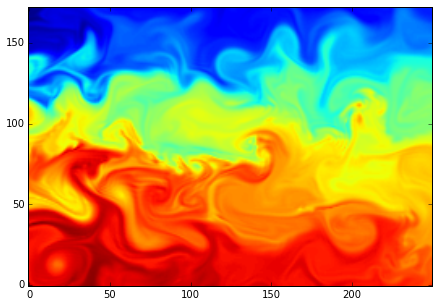

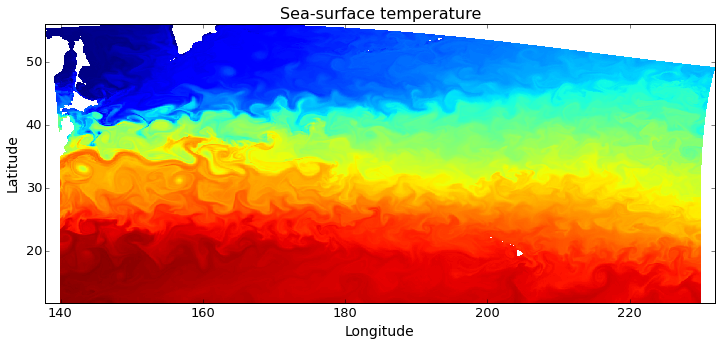

In [4]:
roll = -1000
west, est, sud, nord = 154.9, 180., 30., 45.4
lonrange=np.array([west,est]) 
latrange=np.array([sud,nord])

base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'
fname = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc'
f = netCDF4.Dataset(fname)

SST = np.roll(f.variables['SST'][0], roll)  # SST(time, lat, lon)
U = np.roll(f.variables['U1_1'][0], roll)
tlon = np.roll(f.variables['TLONG'][:], roll)
tlat = np.roll(f.variables['TLAT'][:], roll)

# step 1: figure out the box indices
lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
boxidx = lonmask & latmask # this won't necessarily be square
irange = np.where(boxidx.sum(axis=0))[0]
imin, imax = irange.min(), irange.max()
jrange = np.where(boxidx.sum(axis=1))[0]
jmin, jmax = jrange.min(), jrange.max()
print imin, imax, jmin, jmax

SST_domain = SST[..., jmin:jmax, imin:imax]
U_domain = U[..., jmin:jmax, imin:imax]
jLs, jLe = (1300,1800)
iLs, iLe = (1500,2400)
print tlat[jLs,iLs], tlat[jLe,iLe], tlon[jLs,iLs], tlon[jLe,iLe]

plt.figure(figsize=(18,5))
#plt.subplot(121)
plt.imshow(SST_domain, origin='bottom')
#plt.subplot(122)
plt.figure(figsize=(12,5))
plt.pcolormesh(tlon[jLs:jLe, iLs:iLe], tlat[jLs:jLe, iLs:iLe], SST[..., jLs:jLe, iLs:iLe])
plt.title('Sea-surface temperature',fontsize=16)
plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.axis('tight')

#plt.figure(figsize=(10,10))
#plt.imshow(U_domain, origin='bottom')
print tlon[jLs:jLe, iLs:iLe].shape, tlat[jLs:jLe, iLs:iLe].shape, SST[..., jLs:jLe, iLs:iLe].shape

In [20]:
dlat, dlon = (10., 10.)
#dwest, dsouth = (11., 11.)
lat_start, lat_end = (12., 54.)
lon_start, lon_end = (140., 232.1)
west, south = (lon_start, lat_start)
east, north = (west+dlon, south+dlat)
Degx, Degy = (int((lon_end-lon_start)/dlon), int((lat_end-lat_start)/dlat))
Lon = np.zeros((Degy+1,Degx+1))
Lat = np.zeros((Degy+1,Degx+1))
#Lon_max = np.zeros((Degy,Degx))
#Lat_max = np.zeros((Degy,Degx))
#Lon_upright_corn = 0.
#Lat_upright_corn = 0.
psd_slopes_Feb = np.zeros((Degy,Degx))
psd_slopes_Aug = np.zeros((Degy,Degx))
psd_level_Feb = np.zeros((Degy,Degx))
psd_level_Aug = np.zeros((Degy,Degx))
L_1 = np.zeros((Degy,Degx)) 
base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'

print Degx, Degy
print Lon.shape

9 4
(5, 10)


sstanalysis/popmodel.py:323: UserWarning: The sector has land (land_fraction=0.000777001) but we are interpolating it out.
  warnings.warn(errstr)
sstanalysis/popmodel.py:418: RuntimeWarning: invalid value encountered in divide
  np.bincount(Kidx, weights=(breve2_ave).ravel()) / area )[1:] *Ki*2.*np.pi**2
sstanalysis/popmodel.py:323: UserWarning: The sector has land (land_fraction=9.71251e-05) but we are interpolating it out.
  warnings.warn(errstr)
sstanalysis/popmodel.py:318: UserWarning: The sector has too much land. land_fraction = 0.0143745143745
  warnings.warn(errstr)
-c:3: RuntimeWarning: divide by zero encountered in log2
sstanalysis/popmodel.py:323: UserWarning: The sector has land (land_fraction=0.000811688) but we are interpolating it out.
  warnings.warn(errstr)
sstanalysis/popmodel.py:318: UserWarning: The sector has too much land. land_fraction = 0.0839354205691
  warnings.warn(errstr)
sstanalysis/popmodel.py:318: UserWarning: The sector has too much land. land_fraction 

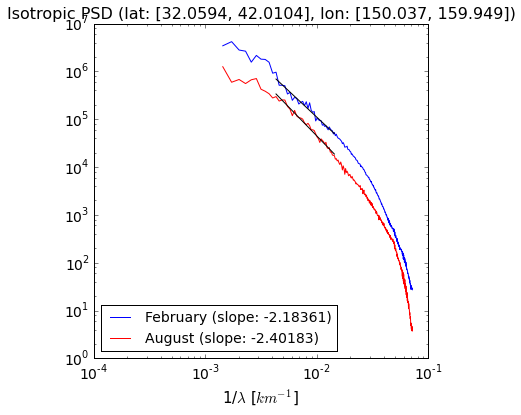

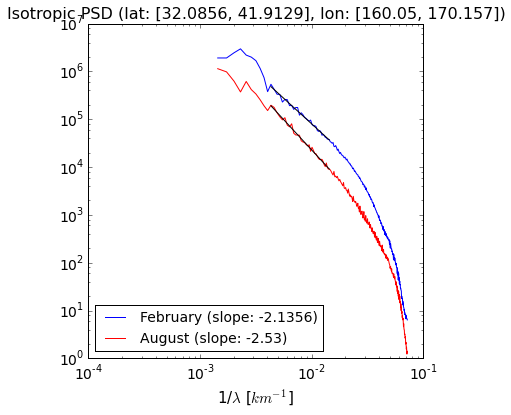

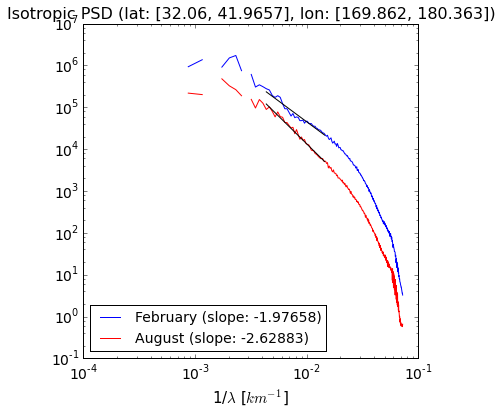

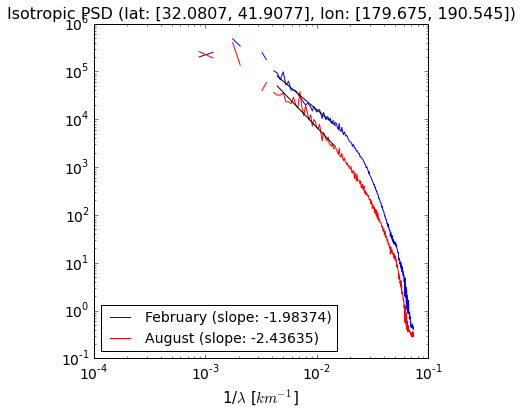

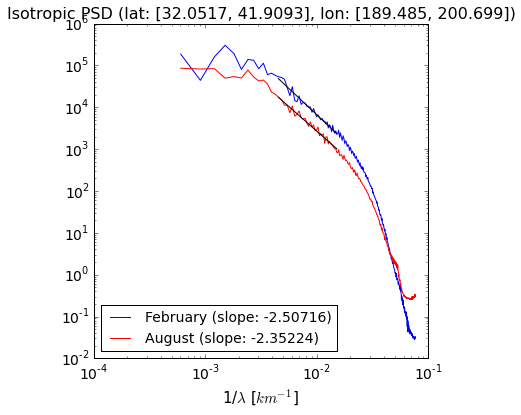

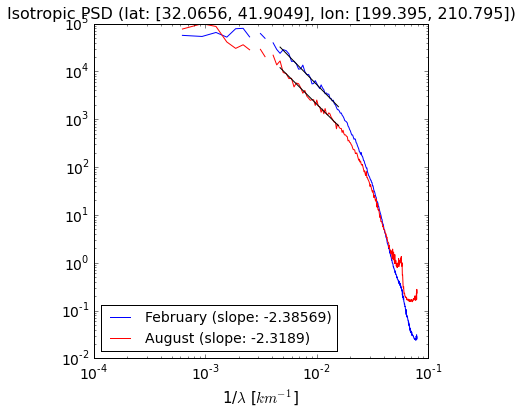

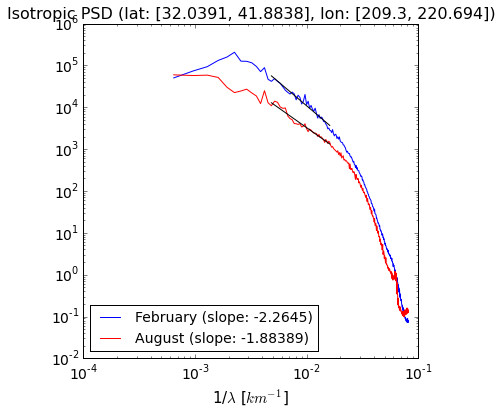

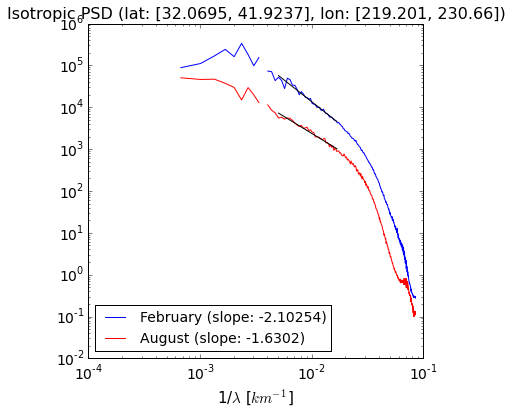

In [21]:
j,i = (0,0)
while north<=lat_end+dlat:
    west = lon_start
    east = west+dlon
    i = 0
    while east<=lon_end+dlon:
        if north <= lat_end:
            if east <= lon_end:
                # February
                NtFeb = 0.
                # load data files
                nday = 1
                for yearnum in np.arange(1,6):
                    daynum = 0
                    #for month in np.arange(1,13):
                    fname = os.path.join(base_dir,
                                 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-02-01.nc' 
                                 % (nday, yearnum+45))
                    #print fname
                    p = popmodel.POPFile(fname)
                    #T = p.nc.variables['SST'][:]
                    Nt_Feb, Nx, Ny, k, l, spac2_ave_Feb, tilde2_ave_Feb, breve2_ave_Feb, Ki, isospec_Feb, area, lon, lat, land_frac, MAX_LAND = p.power_spectrum_2d(
                                                                                                        lonrange=(west,east), latrange=(south,north))
                    if yearnum == 1:
                        N = len(Ki)
                        isospec_sum_Feb = np.zeros(N)
                    isospec_sum_Feb += isospec_Feb
                    #NtFeb += Nt_Feb

                isospec_ave_Feb = isospec_sum_Feb/yearnum
        
                # August
                NtAug = 0.
                # load data files
                nday = 1
                for yearnum in np.arange(1,6):
                    daynum = 0
                    #for month in np.arange(1,13):
                    fname = os.path.join(base_dir, 
                                 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-08-01.nc' 
                                 % (nday, yearnum+45))
                    #print fname
                    p = popmodel.POPFile(fname)
                    #T = p.nc.variables['SST'][:]
                    Nt_Aug, Nx, Ny, k, l, spac2_ave_Aug, tilde2_ave_Aug, breve2_ave_Aug, Ki, isospec_Aug, area, lon, lat, land_frac, MAX_LAND = p.power_spectrum_2d(
                                                                                                            lonrange=(west,east), latrange=(south,north))
                    if yearnum == 1:
                        N = len(Ki)
                        isospec_sum_Aug = np.zeros(N)
                    isospec_sum_Aug += isospec_Aug
                    #NtAug += Nt_Aug

                isospec_ave_Aug = isospec_sum_Aug/yearnum
        
                Ns = 15
                Ne = N/5
                ps_fit_Feb, ps_slope_Feb = fit_loglog(Ki[Ns:Ne], isospec_ave_Feb[Ns:Ne])
                ps_fit_Aug, ps_slope_Aug= fit_loglog(Ki[Ns:Ne], isospec_ave_Aug[Ns:Ne])
        
        roll = -1000
        fname = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc'
        f = netCDF4.Dataset(fname)
        #SST = np.roll(f.variables['SST'][0], roll)  # SST(time, lat, lon)
        #U = np.roll(f.variables['U1_1'][0], roll)
        tlon = np.roll(f.variables['TLONG'][:], roll)
        tlat = np.roll(f.variables['TLAT'][:], roll)

        lonrange=np.array([west,east])
        latrange=np.array([south,north])
        lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
        latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
        boxidx = lonmask & latmask # this won't necessarily be square
        irange = np.where(boxidx.sum(axis=0))[0]
        imin, imax = irange.min(), irange.max()
        jrange = np.where(boxidx.sum(axis=1))[0]
        jmin, jmax = jrange.min(), jrange.max()
        #print imin, imax, jmin, jmax

        #SST_domain = SST[..., jmin:jmax, imin:imax]
        #U_domain = U[..., jmin:jmax, imin:imax]


        if north <= lat_end:
            if east <= lon_end:
                if land_frac<MAX_LAND:
                    Lon[j,i] = tlon[jmin,imin]
                    Lat[j,i] = tlat[jmin,imin]
                    #Lon_max[j,i] = tlon[jmin,imax]
                    #Lat_max[j,i] = tlat[jmax,imin]
                    #Lon_upright_corn = tlon[jmax,imax]
                    #Lat_upright_corn = tlat[jmax,imax]
                    psd_slopes_Feb[j,i] = ps_slope_Feb
                    psd_slopes_Aug[j,i] = ps_slope_Aug
                    psd_level_Feb[j,i] = ps_fit_Feb[-1]
                    psd_level_Aug[j,i] = ps_fit_Aug[-1]
                    L_1[j,i] = Ki[-1]
                    if north > lat_end-2*dlat and north <= lat_end-dlat:
                        plt.figure(figsize=(6,6))
                        #plt.subplot(121)
                        #plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain)
                        #plt.title('SST (Land coverage: %g)' % land_frac, fontsize=16)
                        #plt.xticks(fontsize=14)
                        #plt.yticks(fontsize=14)
                        #plt.subplot(122)
                        plt.loglog(Ki*.5/np.pi*1e3, isospec_ave_Feb, 'b', label=r'February (slope: %g)' % ps_slope_Feb)
                        plt.loglog(Ki*.5/np.pi*1e3, isospec_ave_Aug, 'r', label=r'August (slope: %g)' % ps_slope_Aug)
                        plt.loglog(Ki[Ns:Ne]*.5/np.pi*1e3, ps_fit_Feb, 'k')
                        plt.loglog(Ki[Ns:Ne]*.5/np.pi*1e3, ps_fit_Aug, 'k')
                        plt.xlabel('1/$\lambda$ [$km^{-1}$]', fontsize=15)
                        plt.title('Isotropic PSD (lat: [%g, %g], lon: [%g, %g])' % (tlat[jmin,imin], tlat[jmax,imax], tlon[jmin,imin], tlon[jmax,imax]), fontsize=16)
                        plt.legend(loc='lower left', fontsize=14)
                        plt.xticks(fontsize=14)
                        plt.yticks(fontsize=14)
                else:
                    Lon[j,i] = tlon[jmin,imin]
                    Lat[j,i] = tlat[jmin,imin]
                    #Lon_max[j,i] = tlon[jmin,imax]
                    #Lat_max[j,i] = tlat[jmax,imin]
                    #Lon_upright_corn = tlon[jmax,imax]
                    #Lat_upright_corn = tlat[jmax,imax]
                    psd_slopes_Feb[j,i] = np.nan
                    psd_slopes_Aug[j,i] = np.nan
                    psd_level_Feb[j,i] = np.nan
                    psd_level_Aug[j,i] = np.nan
                    L_1[j,i] = np.nan
            
                    #plt.figure(figsize=(15,4))
                    #plt.subplot(121)
                    #plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain)
                    #plt.title('SST (Land coverage: %g)' % land_frac, fontsize=16)
                    #plt.xticks(fontsize=14)
                    #plt.yticks(fontsize=14)
            else:
                Lon[j,i] = tlon[jmin,imin]
                Lat[j,i] = tlat[jmin,imin]
        else:
            Lon[j,i] = tlon[jmin,imin]
            Lat[j,i] = tlat[jmin,imin]
        
        west = east
        east = west+dlon
        i += 1
    
    south = north
    north = south+dlat
    j += 1
    
    
        

In [24]:
fname = 'psd_slope_SST_Pacific.mat' 
#fw = open(filename, 'w')
io.savemat(fname, {'Feb':psd_slopes_Feb, 'Aug':psd_slopes_Aug, 'Lat':Lat, 'Lon':Lon})

fname = 'psd_level_SST_Pacific.mat' 
#fw = open(filename, 'w')
io.savemat(fname, {'Feb':psd_level_Feb, 'Aug':psd_level_Aug, 'LenScale':(L_1*.5/np.pi)**-1*1e-3})

In [14]:
j,i = (0,0)
land_frac = 0.
MAX_LAND = 0.01
while north<=lat_end+dlat:
    west = lon_start
    east = west+dlon
    i = 0
    while east<=lon_end+dlon:       
        
        roll = -1000
        fname = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc'
        f = netCDF4.Dataset(fname)
        SST_Feb = np.roll(f.variables['SST'][0], roll)  # SST(time, lat, lon)
        fname = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-08-01.nc'
        f = netCDF4.Dataset(fname)
        SST_Aug = np.roll(f.variables['SST'][0], roll)
        tlon = np.roll(f.variables['TLONG'][:], roll)
        tlat = np.roll(f.variables['TLAT'][:], roll)

        lonrange=np.array([west,east])
        latrange=np.array([south,north])
        lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
        latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
        boxidx = lonmask & latmask # this won't necessarily be square
        irange = np.where(boxidx.sum(axis=0))[0]
        imin, imax = irange.min(), irange.max()
        jrange = np.where(boxidx.sum(axis=1))[0]
        jmin, jmax = jrange.min(), jrange.max()
        #print imin, imax, jmin, jmax

        SST_Feb_domain = SST_Feb[..., jmin:jmax, imin:imax]
        SST_Aug_domain = SST_Aug[..., jmin:jmax, imin:imax]
        U_domain = U[..., jmin:jmax, imin:imax]


        if north <= lat_end:
            if east <= lon_end:
                if land_frac<MAX_LAND:
                    Lon[j,i] = tlon[jmin,imin]
                    Lat[j,i] = tlat[jmin,imin]
            
                    plt.figure(figsize=(6,12))
                    plt.subplot(211)
                    plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_Feb_domain)
                    plt.title('SST (February)', fontsize=16)
                    plt.xticks(fontsize=14)
                    plt.yticks(fontsize=14)
                    plt.axis('tight')
                    plt.colorbar()
                    plt.subplot(212)
                    plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_Aug_domain)
                    plt.title('SST (August)', fontsize=16)
                    plt.xticks(fontsize=14)
                    plt.yticks(fontsize=14)
                    plt.axis('tight')
                    plt.colorbar()
                    plt.xticks(fontsize=14)
                    plt.yticks(fontsize=14)
                else:
                    Lon[j,i] = tlon[jmin,imin]
                    Lat[j,i] = tlat[jmin,imin]
            else:
                Lon[j,i] = tlon[jmin,imin]
                Lat[j,i] = tlat[jmin,imin]
        else:
            Lon[j,i] = tlon[jmin,imin]
            Lat[j,i] = tlat[jmin,imin]
        
        west = east
        east = west+dlon
        i += 1
    
    south = north
    north = south+dlat
    j += 1
    
    
        

<matplotlib.colorbar.Colorbar instance at 0x7ffaeb3d19e0>

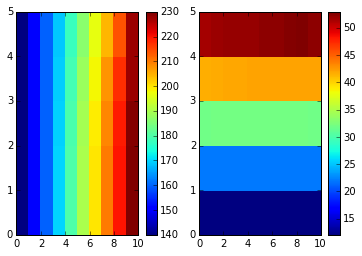

In [8]:
#Lon[:-1,-1] = Lon_max[:,-1]
#Lat[:-1,-1] = Lat_max[:,-1]
#Lon[-1,:-1] = Lon_max[-1,:]
#Lat[-1,:-1] = Lat_max[-1,:]
#Lon[-1,-1] = Lon_upright_corn
#Lat[-1,-1] = Lat_upright_corn

plt.figure()
plt.subplot(121)
plt.pcolormesh(Lon)
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(Lat)
plt.colorbar()

(5, 10)


<matplotlib.colorbar.Colorbar instance at 0x7fbb1c7b91b8>

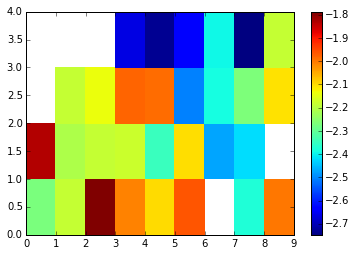

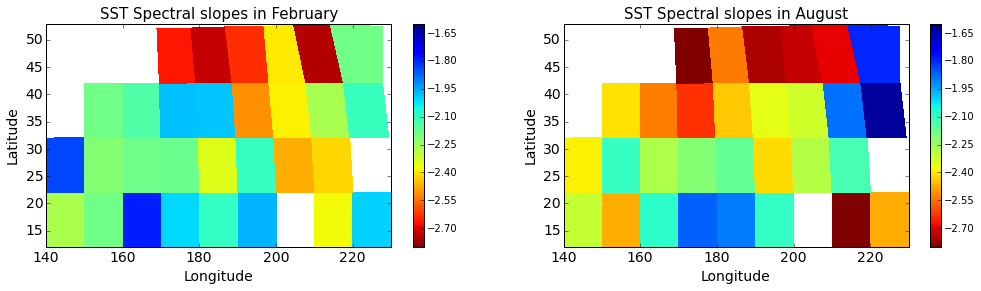

In [23]:
#print slopes_Aug
print Lon.shape

plt.figure()
plt.pcolormesh(np.ma.masked_invalid(psd_slopes_Feb))
plt.colorbar()


plt.figure(figsize=(17,4))
plt.subplot(121)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(psd_slopes_Feb),cmap='jet_r')
plt.title('SST Spectral slopes in February', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-2.8,-1.6])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(psd_slopes_Aug),cmap='jet_r')
plt.title('SST Spectral slopes in August', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-2.8,-1.6])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7fc36c90b200>

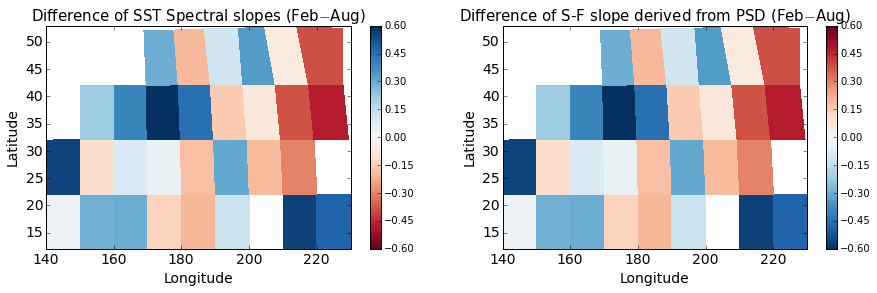

In [18]:
plt.figure(figsize=(15,4))
plt.subplot(121)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(psd_slopes_Feb-psd_slopes_Aug),cmap='RdBu')
plt.title('Difference of SST Spectral slopes (Feb$-$Aug)', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-.6,.6])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid((np.absolute(psd_slopes_Feb)-1.)-(np.absolute(psd_slopes_Aug)-1.)), cmap='RdBu_r')
plt.title('Difference of S-F slope derived from PSD (Feb$-$Aug)', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-.6,.6])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()

In [10]:
#j,i = (0,0)
#L_1 = np.zeros((Degy,Degx))   #inverse wavelength
#psd_level_Feb = np.zeros((Degy,Degx))
#psd_level_Aug = np.zeros((Degy,Degx))
#west, south = (lon_start, lat_start)
#east, north = (west+dlon, south+dlat)

#while north<=lat_end+dlat:
#    west = lon_start
#    east = west+dlon
#    i = 0
#    while east<=lon_end+dlon:
        # February
#        NtFeb = 0.
        # load data files
#        nday = 1
#        for yearnum in np.arange(1,6):
#            daynum = 0
            #for month in np.arange(1,13):
#            fname = os.path.join(base_dir,
#                                 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-02-01.nc' 
#                                 % (nday, yearnum+45))
            #print fname
#            p = popmodel.POPFile(fname)
            #T = p.nc.variables['SST'][:]
#            Nt_Feb, Nx, Ny, k, l, spac2_ave_Feb, tilde2_ave_Feb, breve2_ave_Feb, Ki, isospec_Feb, area, lon, lat, land_frac, MAX_LAND = p.power_spectrum_2d(
#                                                                                                        lonrange=(west,east), latrange=(south,north))
#            if yearnum == 1:
#                N = len(Ki)
#                isospec_sum_Feb = np.zeros(N)
#            isospec_sum_Feb += isospec_Feb
            #NtFeb += Nt_Feb

#        isospec_ave_Feb = isospec_sum_Feb/yearnum
        
        # August
#        NtAug = 0.
        # load data files
#        nday = 1
#        for yearnum in np.arange(1,6):
#            daynum = 0
            #for month in np.arange(1,13):
#            fname = os.path.join(base_dir, 
#                                 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-08-01.nc' 
#                                 % (nday, yearnum+45))
            #print fname
#            p = popmodel.POPFile(fname)
            #T = p.nc.variables['SST'][:]
#            Nt_Aug, Nx, Ny, k, l, spac2_ave_Aug, tilde2_ave_Aug, breve2_ave_Aug, Ki, isospec_Aug, area, lon, lat, land_frac, MAX_LAND = p.power_spectrum_2d(
                                                                                                            lonrange=(west,east), latrange=(south,north))
#            if yearnum == 1:
#                N = len(Ki)
#                isospec_sum_Aug = np.zeros(N)
#            isospec_sum_Aug += isospec_Aug
            #NtAug += Nt_Aug

#        isospec_ave_Aug = isospec_sum_Aug/yearnum
        
#        Ns = 15
#        Ne = N/5
#        ps_fit_Feb, ps_slope_Feb = fit_loglog(Ki[Ns:Ne], isospec_ave_Feb[Ns:Ne])
#        ps_fit_Aug, ps_slope_Aug= fit_loglog(Ki[Ns:Ne], isospec_ave_Aug[Ns:Ne])
        
        #roll = -1000
        #fname = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc'
        #f = netCDF4.Dataset(fname)
        #SST = np.roll(f.variables['SST'][0], roll)  # SST(time, lat, lon)
        #U = np.roll(f.variables['U1_1'][0], roll)
        #tlon = np.roll(f.variables['TLONG'][:], roll)
        #tlat = np.roll(f.variables['TLAT'][:], roll)

        #lonrange=np.array([west,east])
        #latrange=np.array([south,north])
        #lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
        #latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
        #boxidx = lonmask & latmask # this won't necessarily be square
        #irange = np.where(boxidx.sum(axis=0))[0]
        #imin, imax = irange.min(), irange.max()
        #jrange = np.where(boxidx.sum(axis=1))[0]
        #jmin, jmax = jrange.min(), jrange.max()
        #print imin, imax, jmin, jmax

#        SST_domain = SST[..., jmin:jmax, imin:imax]
#        U_domain = U[..., jmin:jmax, imin:imax]


#        if north <= lat_end:
#            if east <= lon_end:
#                if land_frac<MAX_LAND:
                    #Lon[j,i] = tlon[jmin,imin]
                    #Lat[j,i] = tlat[jmin,imin]
                    #Lon_max[j,i] = tlon[jmin,imax]
                    #Lat_max[j,i] = tlat[jmax,imin]
                    #Lon_upright_corn = tlon[jmax,imax]
                    #Lat_upright_corn = tlat[jmax,imax]
#                    psd_level_Feb[j,i] = ps_fit_Feb[-1]
#                    psd_level_Aug[j,i] = ps_fit_Aug[-1]
#                    L_1[j,i] = Ki[-1]
            
                    #plt.figure(figsize=(15,6))
                    #plt.subplot(121)
                    #plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain)
                    #plt.title('SST (Land coverage: %g)' % land_frac, fontsize=16)
                    #plt.xticks(fontsize=14)
                    #plt.yticks(fontsize=14)
                    #plt.subplot(122)
                    #plt.loglog(Ki*1e3, isospec_ave_Feb, 'b', label=r'February (slope: %g)' % ps_slope_Feb)
                    #plt.loglog(Ki*1e3, isospec_ave_Aug, 'r', label=r'August (slope: %g)' % ps_slope_Aug)
                    #plt.loglog(Ki[Ns:Ne]*1e3, ps_fit_Feb, 'k')
                    #plt.loglog(Ki[Ns:Ne]*1e3, ps_fit_Aug, 'k')
                    #plt.xlabel('K [$km^{-1}$]', fontsize=15)
                    #plt.title('Isotropic PSD (lat: [%g, %g], lon: [%g, %g])' % (tlat[jmin,imin], tlat[jmax,imax], tlon[jmin,imin], tlon[jmax,imax]), fontsize=16)
                    #plt.legend(loc='lower left', fontsize=14)
                    #plt.xticks(fontsize=14)
                    #plt.yticks(fontsize=14)
#                else:
                    #Lon[j,i] = tlon[jmin,imin]
                    #Lat[j,i] = tlat[jmin,imin]
                    #Lon_max[j,i] = tlon[jmin,imax]
                    #Lat_max[j,i] = tlat[jmax,imin]
                    #Lon_upright_corn = tlon[jmax,imax]
                    #Lat_upright_corn = tlat[jmax,imax]
#                    psd_level_Feb[j,i] = np.nan
#                    psd_level_Aug[j,i] = np.nan
#                    L_1[j,i] = np.nan
            
                    #plt.figure(figsize=(15,6))
                    #plt.subplot(121)
                    #plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain)
                    #plt.title('SST (Land coverage: %g)' % land_frac, fontsize=16)
                    #plt.xticks(fontsize=14)
                    #plt.yticks(fontsize=14)
            #else:
                #Lon[j,i] = tlon[jmin,imin]
                #Lat[j,i] = tlat[jmin,imin]
        #else:
            #Lon[j,i] = tlon[jmin,imin]
            #Lat[j,i] = tlat[jmin,imin]
        
#        west = east
#        east = west+dlon
#        i += 1
    
#    south = north
#    north = south+dlat
#    j += 1
    
    
        

[         nan          nan  12.04151822  11.8162719   11.70372368
  11.28769306  10.89850423  10.33671831   9.7069863 ]


<matplotlib.colorbar.Colorbar instance at 0x7ffaf1d87098>

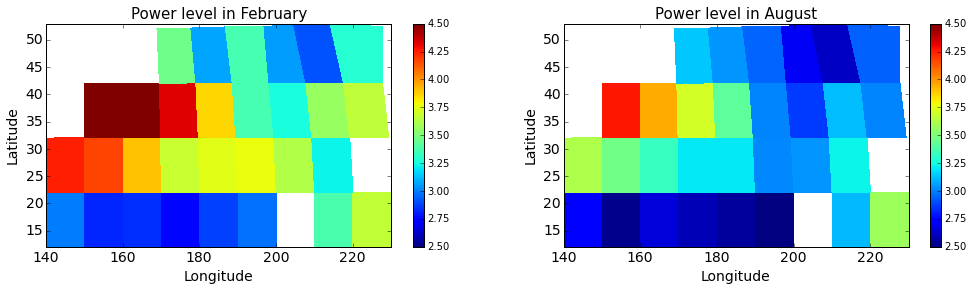

In [11]:
print (L_1[-1]*.5/np.pi)**-1*1e-3

plt.figure(figsize=(17,4))
plt.subplot(121)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(np.log10(psd_level_Feb)))
plt.title('Power level in February', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.clim([2.5,4.5])
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(np.log10(psd_level_Aug)))
plt.title('Power level in August', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.clim([2.5,4.5])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7fc36bd5e3f8>

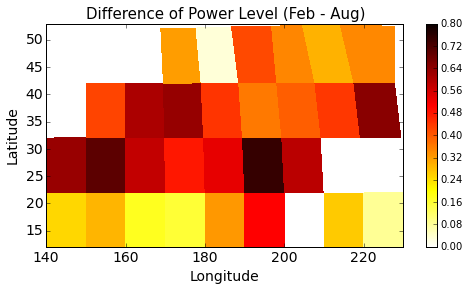

In [25]:
plt.figure(figsize=(8,4))
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(np.log10(psd_level_Feb/psd_level_Aug)),cmap='hot_r')
plt.title('Difference of Power Level (Feb - Aug)', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([0,8e-1])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()

In [ ]:
lat_start, lat_end = (12., 54.)
lon_start, lon_end = (140., 232.1)
west, south = (lon_start, lat_start)
east, north = (west+dlon, south+dlat)

roll = -1000
fname = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-08-01.nc'
f = netCDF4.Dataset(fname)
SST = np.roll(f.variables['SST'][0], roll)  # SST(time, lat, lon)
#U = np.roll(f.variables['U1_1'][0], roll)
tlon = np.roll(f.variables['TLONG'][:], roll)
tlat = np.roll(f.variables['TLAT'][:], roll)

lonrange=np.array([west,east])
latrange=np.array([south,north])
lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
boxidx = lonmask & latmask # this won't necessarily be square
irange = np.where(boxidx.sum(axis=0))[0]
imin, imax = irange.min(), irange.max()
jrange = np.where(boxidx.sum(axis=1))[0]
jmin, jmax = jrange.min(), jrange.max()
#print imin, imax, jmin, jmax

SST_domain_Aug = SST[..., jmin:jmax, imin:imax]

roll = -1000
fname = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc'
f = netCDF4.Dataset(fname)
SST = np.roll(f.variables['SST'][0], roll)  # SST(time, lat, lon)
#U = np.roll(f.variables['U1_1'][0], roll)
tlon = np.roll(f.variables['TLONG'][:], roll)
tlat = np.roll(f.variables['TLAT'][:], roll)

lonrange=np.array([west,east])
latrange=np.array([south,north])
lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
boxidx = lonmask & latmask # this won't necessarily be square
irange = np.where(boxidx.sum(axis=0))[0]
imin, imax = irange.min(), irange.max()
jrange = np.where(boxidx.sum(axis=1))[0]
jmin, jmax = jrange.min(), jrange.max()
#print imin, imax, jmin, jmax

SST_domain_Feb = SST[..., jmin:jmax, imin:imax]

plt.figure(figsize=(8,12))
plt.subplot(211)
plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain_Feb)
plt.title('SST (February)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.colorbar()
plt.subplot(212)
plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain_Aug)
plt.title('SST (August)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.colorbar()

# Structure Function #

/usr/local/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:6164: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
sstanalysis/popmodel.py:489: UserWarning: The sector has land (land_fraction=0.0143745).
  warn(errstr)
-c:3: RuntimeWarning: divide by zero encountered in log2
sstanalysis/popmodel.py:489: UserWarning: The sector has land (land_fraction=0.0839354).
  warn(errstr)
sstanalysis/popmodel.py:489: UserWarning: The sector has land (land_fraction=0.198223).
  warn(errstr)
sstanalysis/popmodel.py:489: UserWarning: The sector has land (land_fraction=0.0175174).
  warn(errstr)


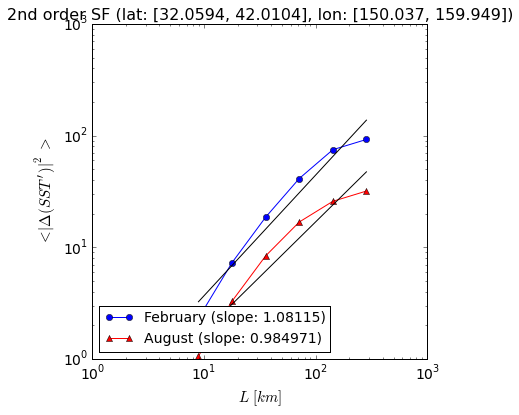

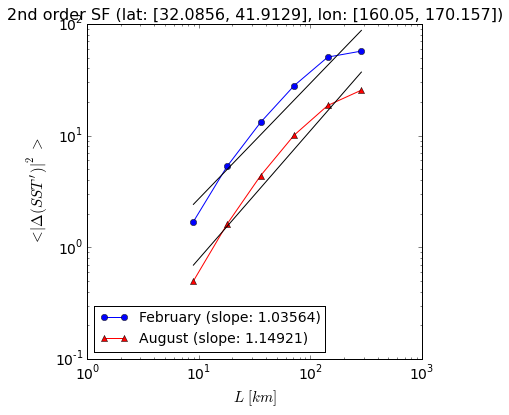

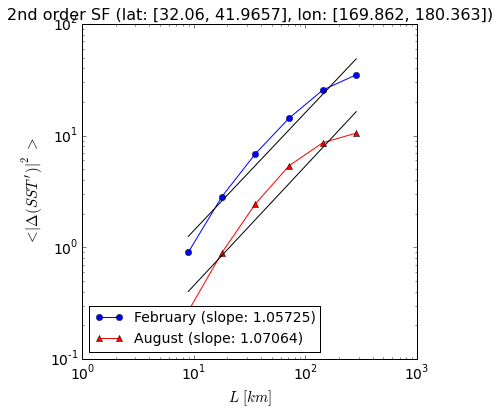

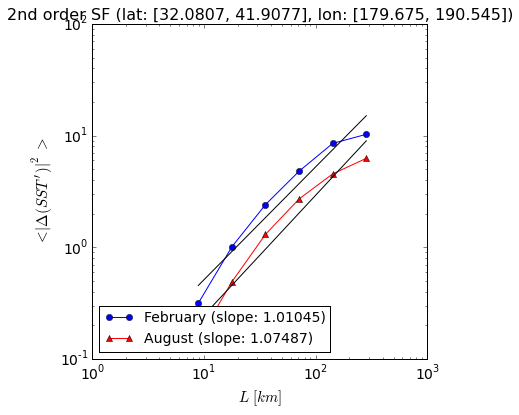

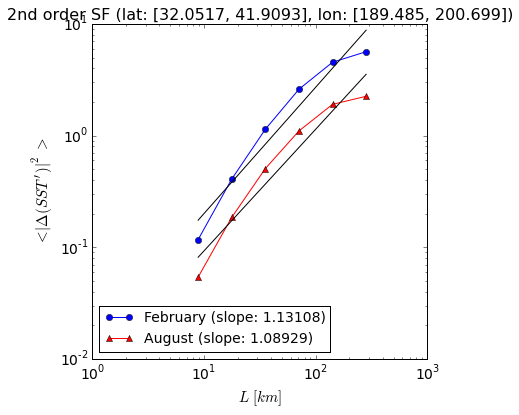

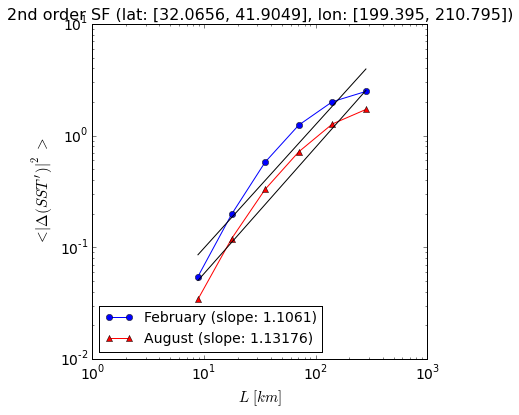

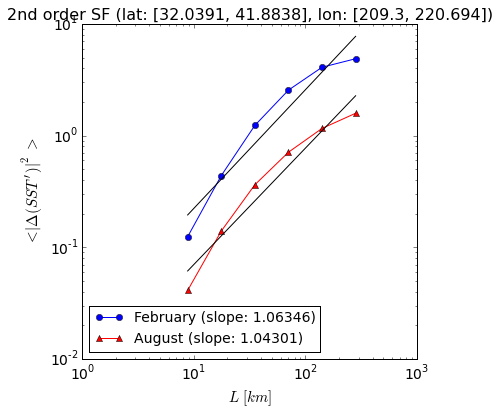

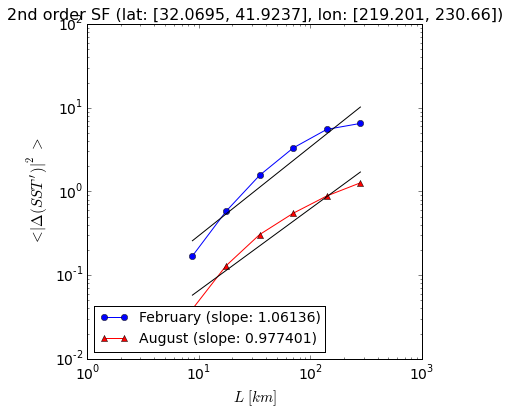

In [5]:
sf_slopes_Feb = np.zeros((Degy,Degx))
sf_slopes_Aug = np.zeros((Degy,Degx))
sf_level_Feb = np.zeros((Degy,Degx))
sf_level_Aug = np.zeros((Degy,Degx))
L_sf = np.zeros((Degy,Degx)) 

j,i = (0,0)
while north<=lat_end+dlat:
    west = lon_start
    east = west+dlon
    i = 0
    while east<=lon_end+dlon:
        if north <= lat_end:
            if east <= lon_end:
                # February
                NtFeb = 0.
                # load data files
                nday = 1
                for yearnum in np.arange(1,6):
                    daynum = 0
                    #for month in np.arange(1,13):
                    fname = os.path.join(base_dir,
                                 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-02-01.nc' 
                                 % (nday, yearnum+45))
                    #print fname
                    p = popmodel.POPFile(fname)
                    #T = p.nc.variables['SST'][:]
                    Nt_Feb, dx, dy, L_Feb, SFi_Feb, SFj_Feb, lon, lat, land_frac, MAX_LAND = p.structure_function(
                                                                                                        lonrange=(west,east), latrange=(south,north))
                    if yearnum == 1:
                        N = len(L_Feb)
                        StrucFunc_sum_Febi = np.zeros(N)
                        StrucFunc_sum_Febj = np.zeros(N)
                    StrucFunc_sum_Febi += SFi_Feb
                    StrucFunc_sum_Febj += SFj_Feb
                    NtFeb += Nt_Feb

                StrucFunc_ave_Febi = StrucFunc_sum_Febi/NtFeb
                StrucFunc_ave_Febj = StrucFunc_sum_Febj/NtFeb
                StrucFunc_ave_Feb = .5*(StrucFunc_ave_Febi+StrucFunc_sum_Febj)
        
                # August
                NtAug = 0.
                # load data files
                nday = 1
                for yearnum in np.arange(1,6):
                    daynum = 0
                    #for month in np.arange(1,13):
                    fname = os.path.join(base_dir, 
                                 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-08-01.nc' 
                                 % (nday, yearnum+45))
                    #print fname
                    p = popmodel.POPFile(fname)
                    #T = p.nc.variables['SST'][:]
                    Nt_Aug, dx, dy, L_Aug, SFi_Aug, SFj_Aug, lon, lat, land_frac, MAX_LAND = p.structure_function(
                                                                                                        lonrange=(west,east), latrange=(south,north))
                    if yearnum == 1:
                        N = len(L_Aug)
                        StrucFunc_sum_Augi = np.zeros(N)
                        StrucFunc_sum_Augj = np.zeros(N)
                    StrucFunc_sum_Augi += SFi_Aug
                    StrucFunc_sum_Augj += SFj_Aug
                    NtAug += Nt_Aug

                StrucFunc_ave_Augi = StrucFunc_sum_Augi/NtAug
                StrucFunc_ave_Augj = StrucFunc_sum_Augj/NtAug
                StrucFunc_ave_Aug = .5*(StrucFunc_ave_Augi+StrucFunc_sum_Augj)
        
                sf_fit_Feb, sf_slope_Feb = fit_loglog(L_Feb, StrucFunc_ave_Feb)
                sf_fit_Aug, sf_slope_Aug = fit_loglog(L_Aug, StrucFunc_ave_Aug)
        
        roll = -1000
        fname = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc'
        f = netCDF4.Dataset(fname)
        SST = np.roll(f.variables['SST'][0], roll)  # SST(time, lat, lon)
        U = np.roll(f.variables['U1_1'][0], roll)
        tlon = np.roll(f.variables['TLONG'][:], roll)
        tlat = np.roll(f.variables['TLAT'][:], roll)

        lonrange=np.array([west,east])
        latrange=np.array([south,north])
        lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
        latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
        boxidx = lonmask & latmask # this won't necessarily be square
        irange = np.where(boxidx.sum(axis=0))[0]
        imin, imax = irange.min(), irange.max()
        jrange = np.where(boxidx.sum(axis=1))[0]
        jmin, jmax = jrange.min(), jrange.max()
        #print imin, imax, jmin, jmax

        SST_domain = SST[..., jmin:jmax, imin:imax]
        U_domain = U[..., jmin:jmax, imin:imax]

        #N = len(StrucFunc_ave_Feb)
        x = 2**np.arange(N)*dx*1e-3
        y = 2**np.arange(N)*dy*1e-3

        if north <= lat_end:
            if east <= lon_end:
                if land_frac<MAX_LAND:
                    Lon[j,i] = tlon[jmin,imin]
                    Lat[j,i] = tlat[jmin,imin]
                    sf_slopes_Feb[j,i] = sf_slope_Feb
                    sf_slopes_Aug[j,i] = sf_slope_Aug
                    sf_level_Feb[j,i] = sf_fit_Feb[0]
                    sf_level_Aug[j,i] = sf_fit_Aug[0]
                    L_sf[j,i] = L_Feb[0]
                    if north > lat_end-2*dlat and north <= lat_end-dlat:
                        plt.figure(figsize=(6,6))
                        #plt.subplot(121)
                        #plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain)
                        #plt.title('SST (Land coverage: %g)' % land_frac, fontsize=16)
                        #plt.xticks(fontsize=14)
                        #plt.yticks(fontsize=14)
                        #plt.subplot(122)
                        plt.loglog(x, StrucFunc_ave_Feb, 'bo-', label=r'February (slope: %g)' % sf_slope_Feb)
                        plt.loglog(x, StrucFunc_ave_Aug, 'r^-', label=r'August (slope: %g)' % sf_slope_Aug) 
                        plt.loglog(x, sf_fit_Feb, 'k')
                        plt.loglog(x, sf_fit_Aug, 'k')
                        plt.xlabel('$L \  [km]$', fontsize=15)
                        plt.ylabel('$< {| \Delta ({SST}^{\ \prime}) |}^2 >$', fontsize=15)
                        plt.title('2nd order SF (lat: [%g, %g], lon: [%g, %g])' % (tlat[jmin,imin], tlat[jmax,imax], tlon[jmin,imin], tlon[jmax,imax]), fontsize=16)
                        plt.legend(loc='lower left', fontsize=14)
                        plt.xticks(fontsize=14)
                        plt.yticks(fontsize=14)
                else:
                    Lon[j,i] = tlon[jmin,imin]
                    Lat[j,i] = tlat[jmin,imin]
                    sf_slopes_Feb[j,i] = np.nan
                    sf_slopes_Aug[j,i] = np.nan
                    sf_level_Feb[j,i] = np.nan
                    sf_level_Aug[j,i] = np.nan
                    L_sf[j,i] = np.nan
            
                    #plt.figure(figsize=(15,6))
                    #plt.subplot(121)
                    #plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain)
                    #plt.title('SST (Land coverage: %g)' % land_frac, fontsize=16)
                    #plt.xticks(fontsize=14)
                    #plt.yticks(fontsize=14)
            else:
                Lon[j,i] = tlon[jmin,imin]
                Lat[j,i] = tlat[jmin,imin]
        else:
            Lon[j,i] = tlon[jmin,imin]
            Lat[j,i] = tlat[jmin,imin]
        

        west = east
        east = west+dlon
        i += 1
    south = north
    north = south+dlat
    j += 1

In [6]:
fname = 'sf_slope_SST_Pacific.mat' 
#fw = open(filename, 'w')
io.savemat(fname, {'Feb':sf_slopes_Feb, 'Aug':sf_slopes_Aug, 'Lat':Lat, 'Lon':Lon})

fname = 'sf_level_SST_Pacific.mat' 
#fw = open(filename, 'w')
io.savemat(fname, {'Feb':sf_level_Feb, 'Aug':sf_level_Aug, 'LenScale':L_sf})

In [4]:
fname = 'sf_slope_SST_Pacific.mat'
f_sf = io.loadmat(fname)

print f_sf.keys()

fname = 'psd_slope_SST_Pacific.mat'
f_psd = io.loadmat(fname)

print f_psd.keys()

['Feb', 'Aug', 'Lon', '__header__', '__globals__', 'Lat', '__version__']
['Feb', 'Aug', 'Lon', '__header__', '__globals__', 'Lat', '__version__']


In [11]:
psd_slopes_Feb = f_psd['Feb']
psd_slopes_Aug = f_psd['Aug']

sf_slopes_Feb = f_sf['Feb']
sf_slopes_Aug = f_sf['Aug']
Lon = f_sf['Lon']
Lat = f_sf['Lat']

<matplotlib.colorbar.Colorbar instance at 0x7fbb2309fea8>

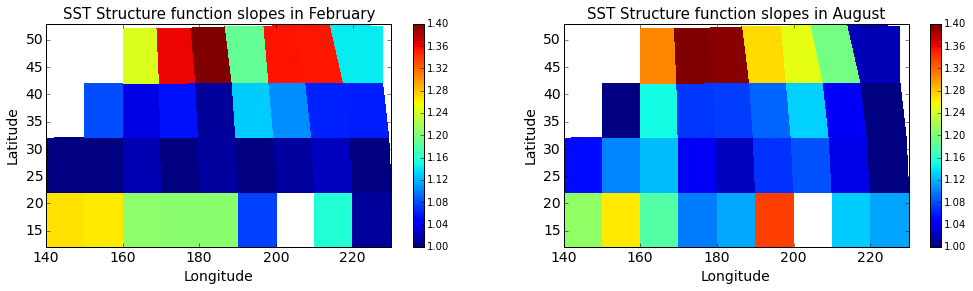

In [12]:
plt.figure(figsize=(17,4))
plt.subplot(121)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(sf_slopes_Feb), cmap='jet')
plt.title('SST Structure function slopes in February', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([1,1.4])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(sf_slopes_Aug), cmap='jet')
plt.title('SST Structure function slopes in August', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([1,1.4])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7fbb228bab90>

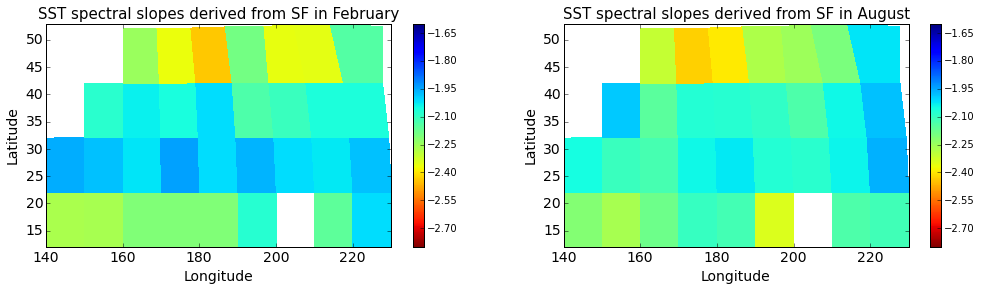

In [15]:
plt.figure(figsize=(17,4))
plt.subplot(121)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(-sf_slopes_Feb-1), cmap='jet_r')
plt.title('SST spectral slopes derived from SF in February', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-2.8,-1.6])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(-sf_slopes_Aug-1), cmap='jet_r')
plt.title('SST spectral slopes derived from SF in August', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-2.8,-1.6])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7fbb21f12368>

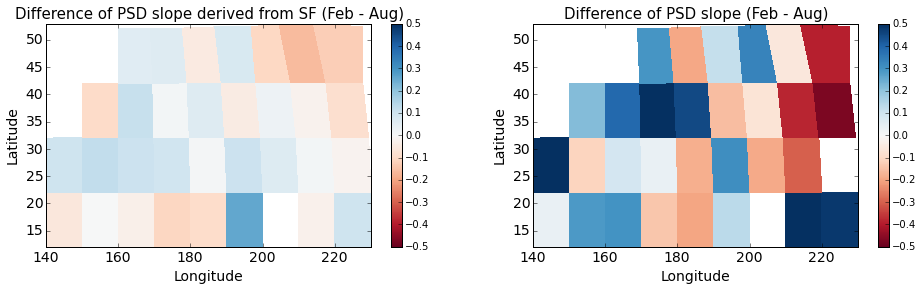

In [25]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(-(sf_slopes_Feb+1)+(sf_slopes_Aug+1)), cmap='RdBu')
plt.title('Difference of PSD slope derived from SF (Feb - Aug)', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-.5,.5])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(psd_slopes_Feb-psd_slopes_Aug), cmap='RdBu')
plt.title('Difference of PSD slope (Feb - Aug)', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-.5,.5])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()

#Expand Domain#

In [4]:
dlat, dlon = (10., 10.)
#dwest, dsouth = (11., 11.)
lat_start, lat_end = (-60., 50.)
lon_start, lon_end = (12., 332.)
west, south = (lon_start, lat_start)
east, north = (west+dlon, south+dlat)
Degx, Degy = (int((lon_end-lon_start)/dlon), int((lat_end-lat_start)/dlat))
lon_global = np.arange(lon_start, lon_end+2*dlon, dlon)
lat_global = np.arange(lat_start, lat_end+2*dlat, dlat)
Lon_global, Lat_global = np.meshgrid(lon_global, lat_global)
#Lon_global = np.zeros((Degy+2,Degx+2))
#Lat_global = np.zeros((Degy+2,Degx+2))
#Lon_max = np.zeros((Degy,Degx))
#Lat_max = np.zeros((Degy,Degx))
#Lon_upright_corn = 0.
#Lat_upright_corn = 0.
psd_slopes_Feb_global = np.zeros((Degy+1,Degx+1))
psd_slopes_Aug_global = np.zeros((Degy+1,Degx+1))
psd_level_Feb_global = np.zeros((Degy+1,Degx+1))
psd_level_Aug_global = np.zeros((Degy+1,Degx+1))
L_1_global = np.zeros((Degy+1,Degx+1)) 
base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'

print Degx, Degy
print Lon_global.shape

32 11
(13, 34)


In [5]:
roll = -1080

fname = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-08-01.nc'
f = netCDF4.Dataset(fname)
mask = f.variables['KMT'][:] <= 1
SST = np.roll(np.ma.masked_array(f.variables['SST'][0],mask), roll, axis=1)  # SST(time, lat, lon)
#U = np.roll(f.variables['U1_1'][0], roll)
tlon = np.roll(np.ma.masked_array(f.variables['TLONG'][:],mask), roll, axis=1)
tlat = np.roll(np.ma.masked_array(f.variables['TLAT'][:],mask), roll, axis=1)


lonrange=np.array([lon_start, lon_end])
latrange=np.array([lat_start, lat_end])
lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
boxidx = lonmask & latmask # this won't necessarily be square
irange = np.where(boxidx.sum(axis=0))[0]
imin_bound, imax_bound = irange.min(), irange.max()
jrange = np.where(boxidx.sum(axis=1))[0]
jmin_bound, jmax_bound = jrange.min(), jrange.max()
#print imin, imax, jmin, jmax
#region_mask = np.roll(mask, roll, axis=1)[jmin_bound:jmax_bound, imin_bound:imax_bound]

<matplotlib.colorbar.Colorbar instance at 0x7f0f57684d40>

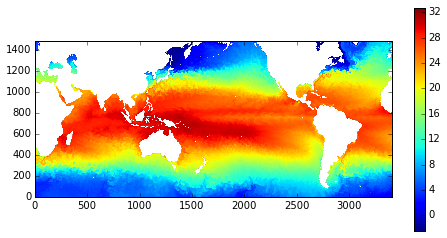

In [30]:
SST_domain_Aug = SST[..., jmin_bound:jmax_bound+100, imin_bound:imax_bound+100]

fname = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc'
f = netCDF4.Dataset(fname)
mask = f.variables['KMT'][:] <= 1
SST = np.roll(np.ma.masked_array(f.variables['SST'][0],mask), roll, axis=1)  # SST(time, lat, lon)
#U = np.roll(f.variables['U1_1'][0], roll)
#tlon = np.roll(f.variables['TLONG'][:], roll)
#tlat = np.roll(f.variables['TLAT'][:], roll)

SST_domain_Feb = SST[..., jmin_bound:jmax_bound+100, imin_bound:imax_bound+100]

plt.figure(figsize=(8,4))
plt.imshow(SST_domain_Feb, origin='bottom')
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f0f3d506ea8>

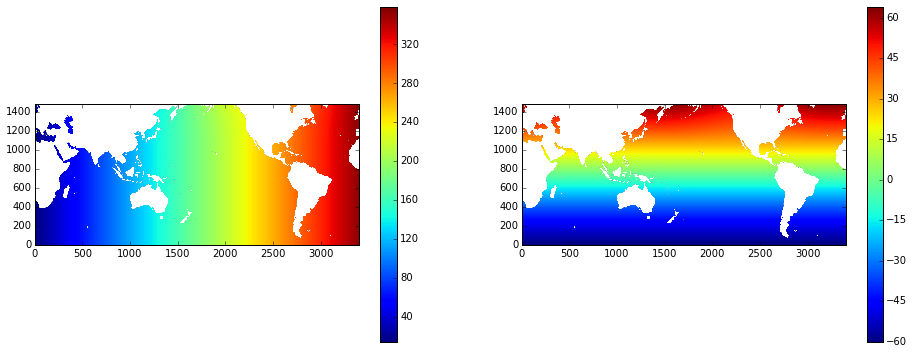

In [31]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.imshow(tlon[jmin_bound:jmax_bound+100, imin_bound:imax_bound+100], origin='bottom')
plt.colorbar()
plt.subplot(122)
plt.imshow(tlat[jmin_bound:jmax_bound+100, imin_bound:imax_bound+100], origin='bottom')
plt.colorbar()

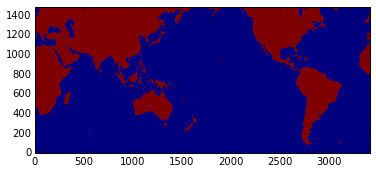

In [32]:
plt.figure()
plt.imshow(np.roll(mask,roll,axis=1)[jmin_bound:jmax_bound+100, imin_bound:imax_bound+100], origin='bottom')

0.000425007220584


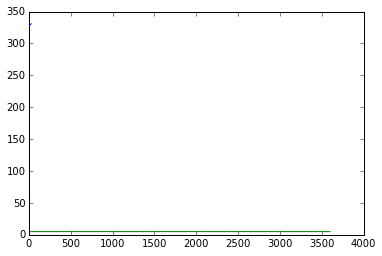

In [17]:
print np.nanmin(tlon)

plt.figure()
plt.plot(tlon[jmax/2, imin:imax])
plt.plot(5*np.ones(tlon.shape[1]))

(14.049999999999995,
 351.5437506682195,
 -59.964214631430728,
 59.835483700495189)

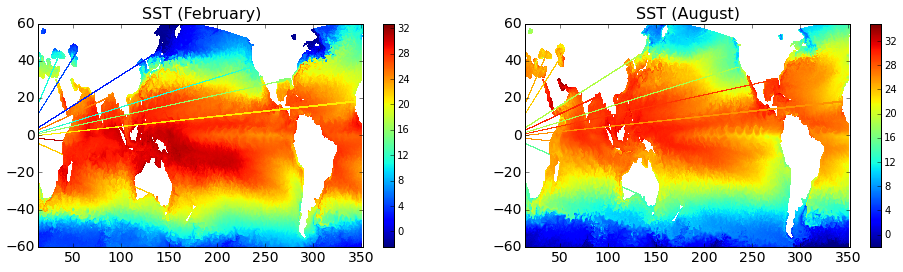

In [42]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.pcolormesh(tlon[jmin_bound:jmax_bound, imin_bound:imax_bound], tlat[jmin_bound:jmax_bound, imin_bound:imax_bound], SST_domain_Feb)
plt.title('SST (February)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.colorbar()
plt.axis('tight')
plt.subplot(122)
plt.pcolormesh(tlon[jmin_bound:jmax_bound, imin_bound:imax_bound], tlat[jmin_bound:jmax_bound, imin_bound:imax_bound], SST_domain_Aug)
plt.title('SST (August)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.colorbar()
plt.axis('tight')

In [6]:
roll = -1080
fname = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc'
f = netCDF4.Dataset(fname)
mask = f.variables['KMT'][:] <= 1
SST = np.roll(np.ma.masked_array(f.variables['SST'][0],mask), roll, axis=1)[jmin_bound:jmax_bound+100, imin_bound:imax_bound+100]  # SST(time, lat, lon)
#U = np.roll(f.variables['U1_1'][0], roll)
tlon = np.roll(np.ma.masked_array(f.variables['TLONG'][:],mask), roll, axis=1)[jmin_bound:jmax_bound+100, imin_bound:imax_bound+100]
tlat = np.roll(np.ma.masked_array(f.variables['TLAT'][:],mask), roll, axis=1)[jmin_bound:jmax_bound+100, imin_bound:imax_bound+100]
#tlon = np.roll(f.variables['TLONG'][:], roll)
#tlat = np.roll(f.variables['TLAT'][:], roll)
mask_global = np.roll(mask, roll, axis=1)[jmin_bound:jmax_bound+100, imin_bound:imax_bound+100]

In [ ]:
Ny, Nx = tlon.shape
x = np.arange(0,Nx)
y = np.arange(0,Ny)
X,Y = np.meshgrid(x,y)
Zr = tlon.ravel()
Xr = np.ma.masked_array(X.ravel(), Zr.mask)
Yr = np.ma.masked_array(Y.ravel(), Zr.mask)
Xm = np.ma.masked_array( Xr.data, ~Xr.mask ).compressed()
Ym = np.ma.masked_array( Yr.data, ~Yr.mask ).compressed()
Zm = naiso.griddata(np.array([Xr.compressed(), Yr.compressed()]).T, 
                                    Zr.compressed(), np.array([Xm,Ym]).T, method='linear')
Znew = Zr.data
Znew[Zr.mask] = Zm
Znew.shape = tlon.shape
tlon = Znew.copy()

Zr = tlat.ravel()
Xr = np.ma.masked_array(X.ravel(), Zr.mask)
Yr = np.ma.masked_array(Y.ravel(), Zr.mask)
Xm = np.ma.masked_array( Xr.data, ~Xr.mask ).compressed()
Ym = np.ma.masked_array( Yr.data, ~Yr.mask ).compressed()
Zm = naiso.griddata(np.array([Xr.compressed(), Yr.compressed()]).T, 
                                    Zr.compressed(), np.array([Xm,Ym]).T, method='linear')
Znew = Zr.data
Znew[Zr.mask] = Zm
Znew.shape = tlat.shape
tlat = Znew.copy()

<matplotlib.colorbar.Colorbar instance at 0x7f9070fe8830>

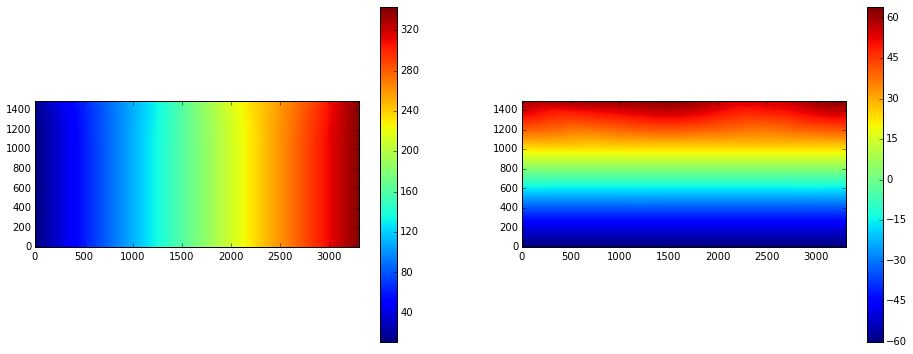

In [9]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.imshow(tlon, origin='bottom')
plt.colorbar()
plt.subplot(122)
plt.imshow(tlat, origin='bottom')
plt.colorbar()

In [86]:
print tlon.shape, tlat.shape, SST.shape

(1488, 3407) (1488, 3407) (1488, 3407)


(11.249999999999996,
 354.85194770437391,
 -59.964214631430728,
 63.982440525489167)

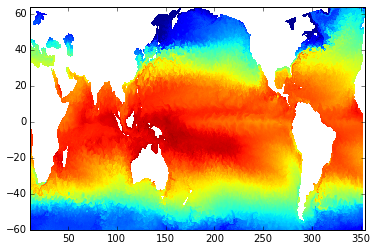

In [87]:
plt.figure()
plt.pcolormesh(tlon,tlat,SST)
plt.axis('tight')

In [52]:
print jmin_bound, jmax_bound

428 1816


In [108]:
crit = 0.01
lat_start_eq = -10.
lat_end_eq = 0.
west, south = (lon_start, lat_start_eq)
east, north = (west+dlon, south+dlat)
Degx_eq, Degy_eq = (int((lon_end-lon_start)/dlon), int((lat_end_eq-lat_start_eq)/dlat))
#Lon_eq = np.zeros((Degy_eq+2,Degx_eq+2))
#Lat_eq = np.zeros((Degy_eq+2,Degx_eq+2))
lon_eq = np.arange(lon_start, lon_end+2*dlon, dlon)
lat_eq = np.arange(lat_start_eq, lat_end_eq+2*dlat, dlat)
Lon_eq, Lat_eq = np.meshgrid(lon_eq, lat_eq)

print Lon_eq.shape, Lat_eq.shape

(3, 35) (3, 35)


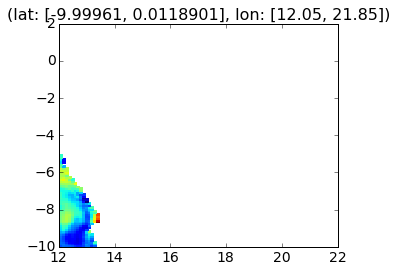

Too much land coverage to calculate spectra
Westend longtitude is:  12.05


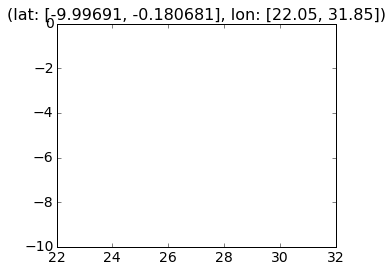

Too much land coverage to calculate spectra
Westend longtitude is:  22.05


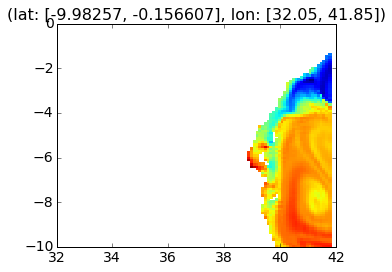

Too much land coverage to calculate spectra
Westend longtitude is:  32.05


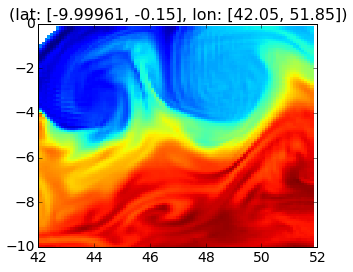

Index range (i):  308 407
Index range (j):  653 753
PSD slopes (Feb):  -2.53294689287


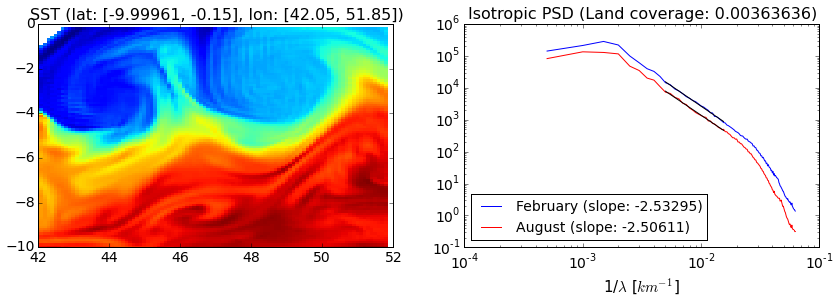

Westend longtitude is:  42.05


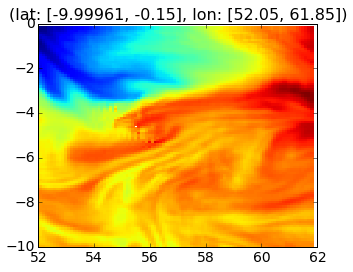

Index range (i):  408 507
Index range (j):  653 753
PSD slopes (Feb):  -2.21510117164


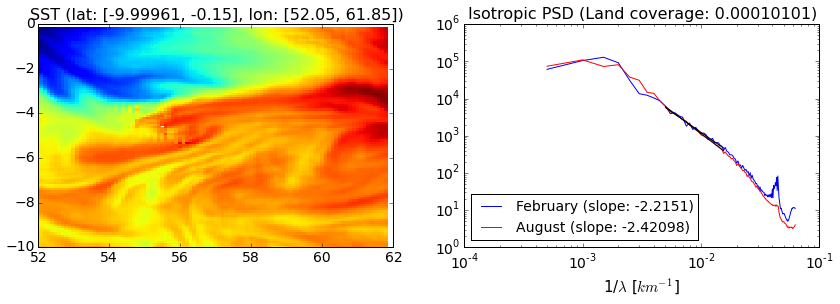

Westend longtitude is:  52.05


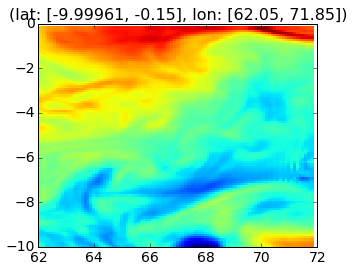

Index range (i):  508 607
Index range (j):  653 753
PSD slopes (Feb):  -2.14608866737


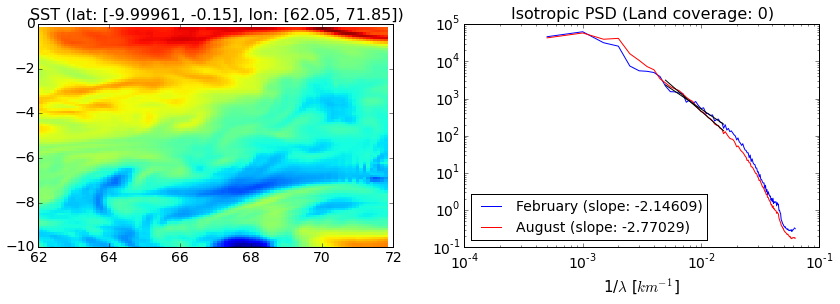

Westend longtitude is:  62.05


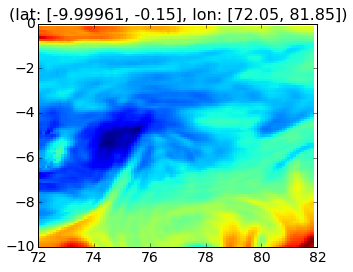

Index range (i):  608 707
Index range (j):  653 753
PSD slopes (Feb):  -2.55050941316


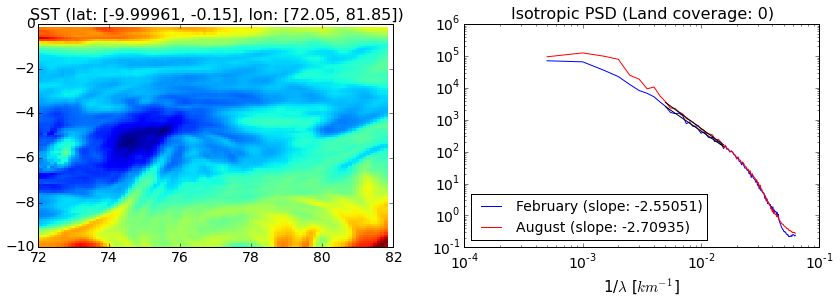

Westend longtitude is:  72.05


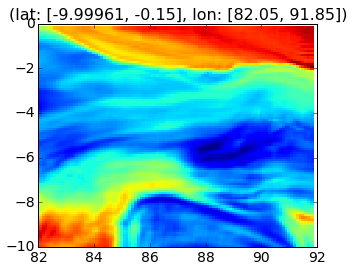

Index range (i):  708 807
Index range (j):  653 753
PSD slopes (Feb):  -2.57225272188


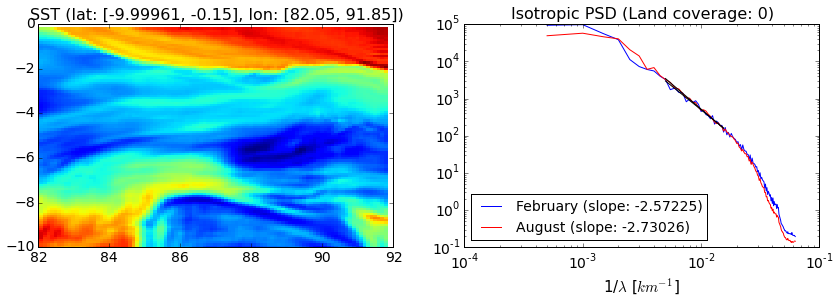

Westend longtitude is:  82.05


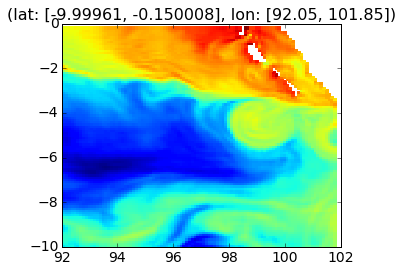

Too much land coverage to calculate spectra
Westend longtitude is:  92.05


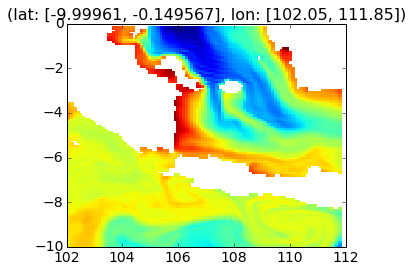

Too much land coverage to calculate spectra
Westend longtitude is:  102.05


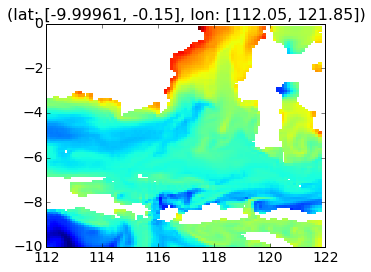

Too much land coverage to calculate spectra
Westend longtitude is:  112.05


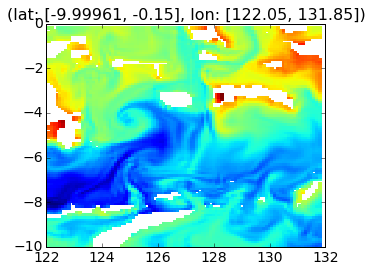

Too much land coverage to calculate spectra
Westend longtitude is:  122.05


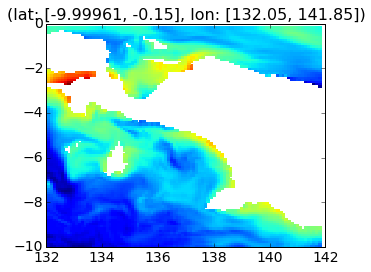

Too much land coverage to calculate spectra
Westend longtitude is:  132.05


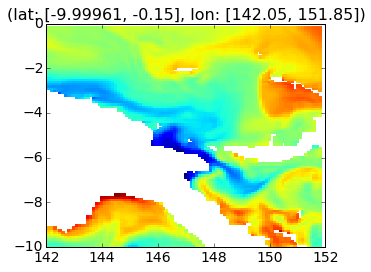

Too much land coverage to calculate spectra
Westend longtitude is:  142.05


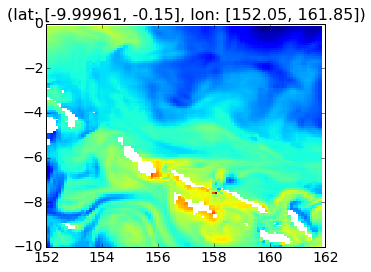

Too much land coverage to calculate spectra
Westend longtitude is:  152.05


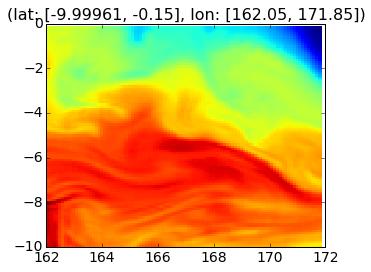

Index range (i):  1508 1607
Index range (j):  653 753
PSD slopes (Feb):  -2.49357949403


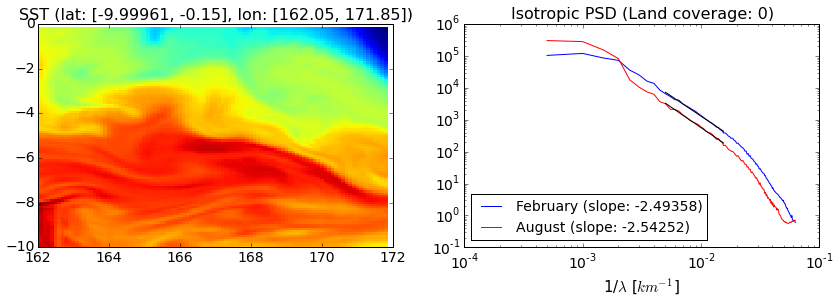

Westend longtitude is:  162.05


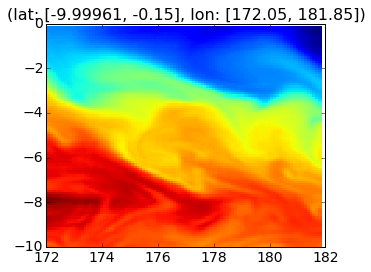

Index range (i):  1608 1707
Index range (j):  653 753
PSD slopes (Feb):  -2.6680931203


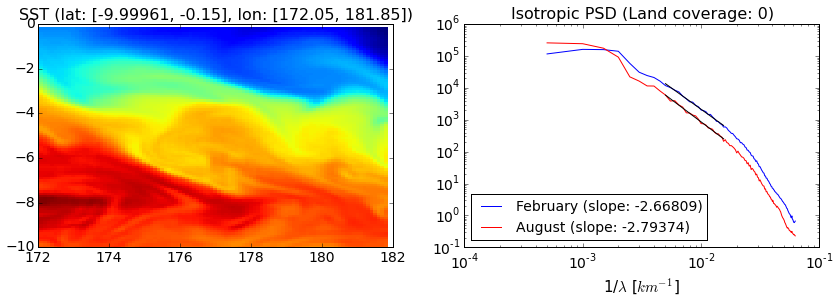

Westend longtitude is:  172.05


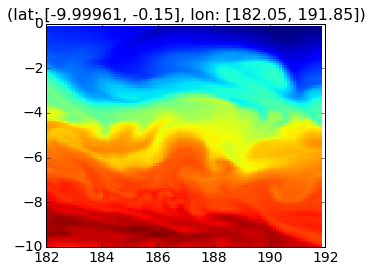

Index range (i):  1708 1807
Index range (j):  653 753
PSD slopes (Feb):  -2.66516661913


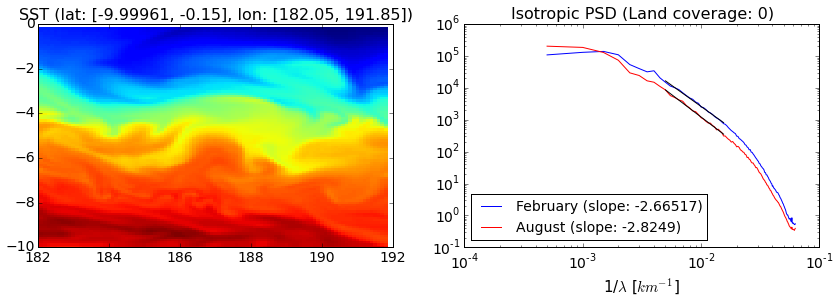

Westend longtitude is:  182.05


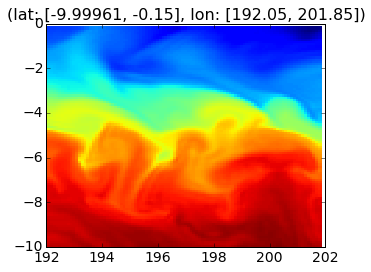

Index range (i):  1808 1907
Index range (j):  653 753
PSD slopes (Feb):  -2.76458201972


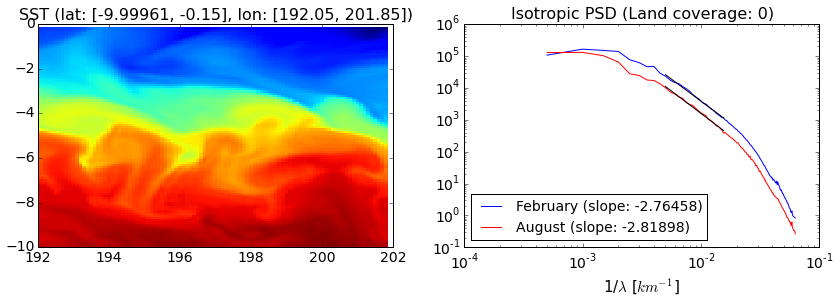

Westend longtitude is:  192.05


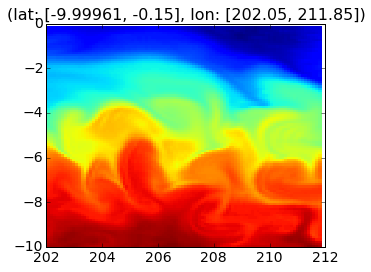

Index range (i):  1908 2007
Index range (j):  653 753
PSD slopes (Feb):  -2.55583457381


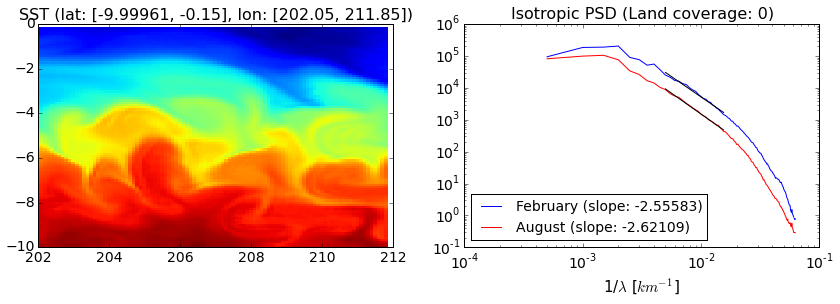

Westend longtitude is:  202.05


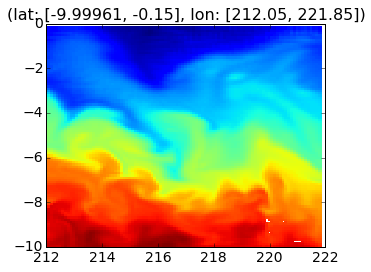

Index range (i):  2008 2107
Index range (j):  653 753
PSD slopes (Feb):  -2.58320952608


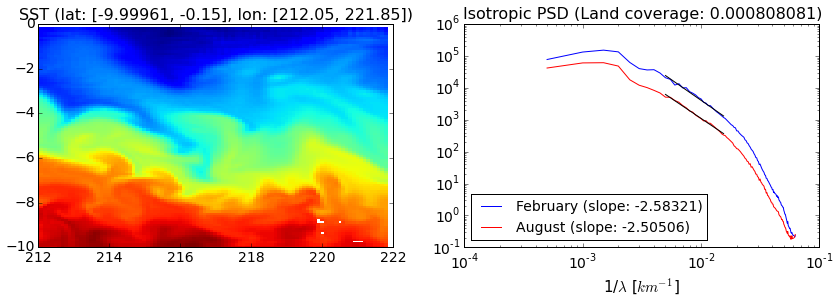

Westend longtitude is:  212.05


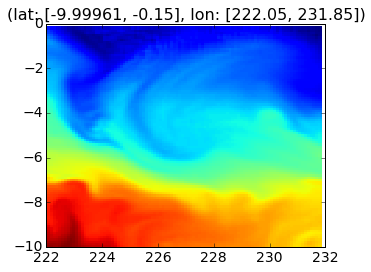

Index range (i):  2108 2207
Index range (j):  653 753
PSD slopes (Feb):  -2.63974147871


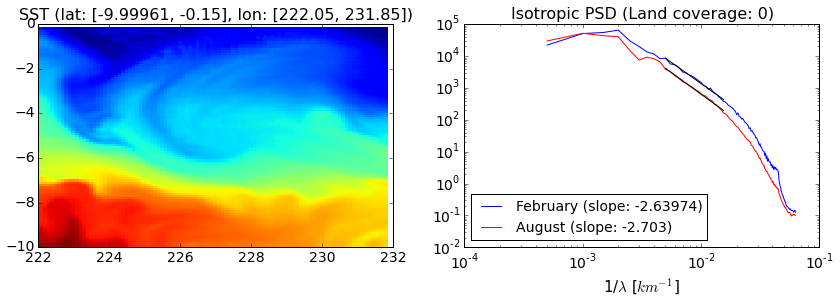

Westend longtitude is:  222.05


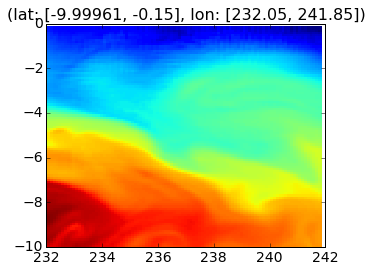

Index range (i):  2208 2307
Index range (j):  653 753
PSD slopes (Feb):  -3.27047453168


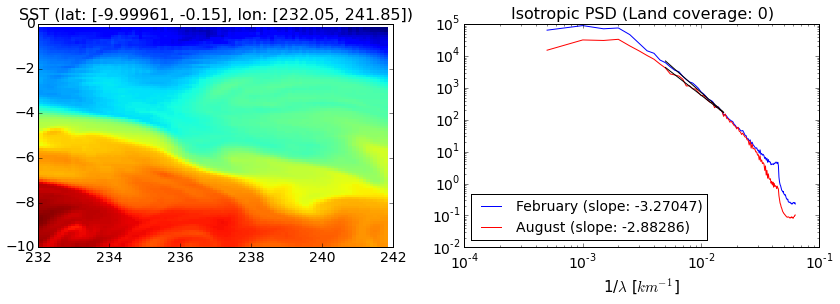

Westend longtitude is:  232.05


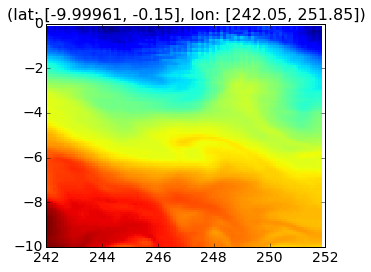

Index range (i):  2308 2407
Index range (j):  653 753
PSD slopes (Feb):  -3.17370035406


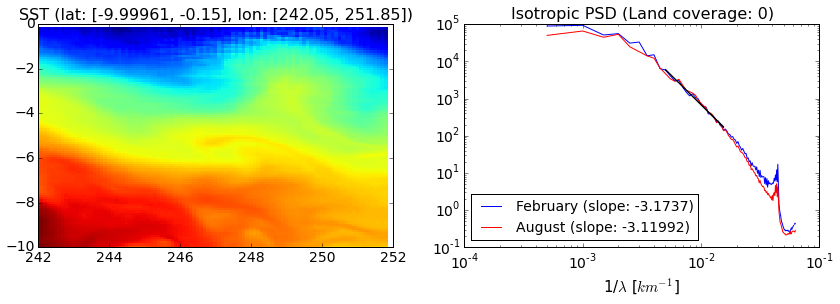

Westend longtitude is:  242.05


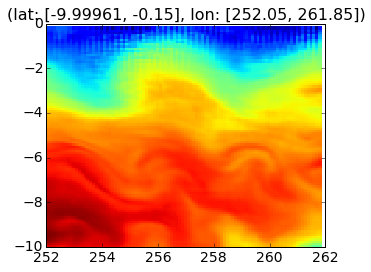

Index range (i):  2408 2507
Index range (j):  653 753
PSD slopes (Feb):  -2.71852418534


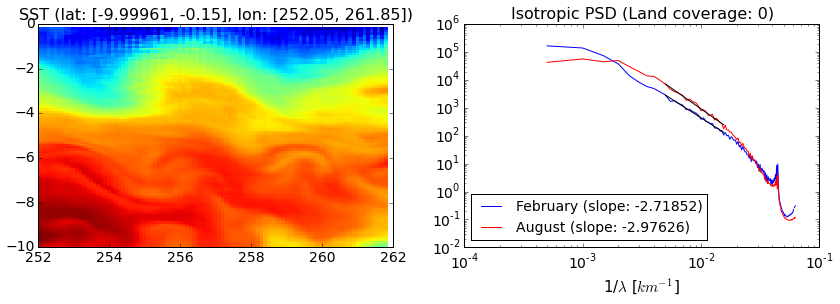

Westend longtitude is:  252.05


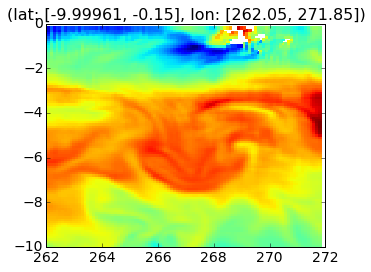

Index range (i):  2508 2607
Index range (j):  653 753
PSD slopes (Feb):  -2.30232033204


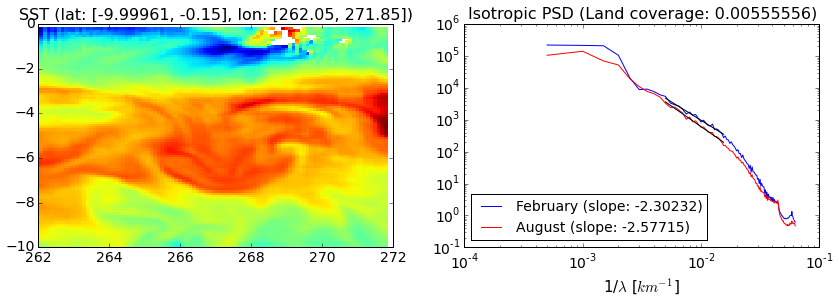

Westend longtitude is:  262.05


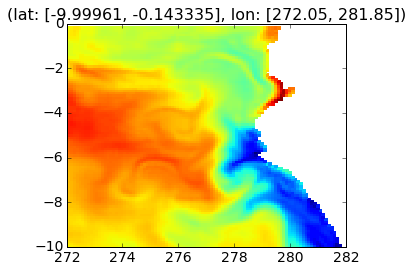

Too much land coverage to calculate spectra
Westend longtitude is:  272.05


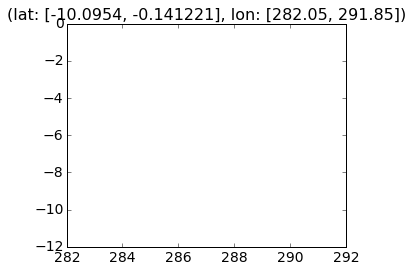

Too much land coverage to calculate spectra
Westend longtitude is:  282.05


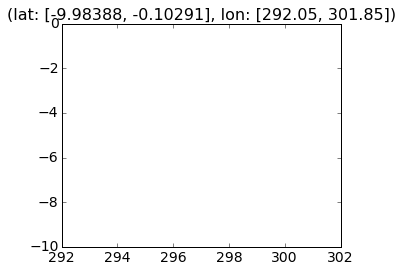

Too much land coverage to calculate spectra
Westend longtitude is:  292.05


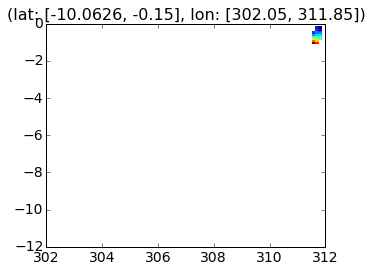

Too much land coverage to calculate spectra
Westend longtitude is:  302.05


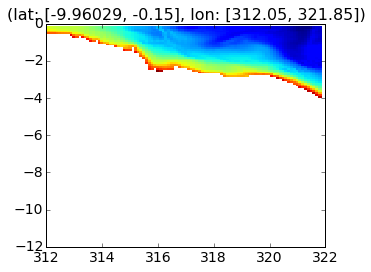

Too much land coverage to calculate spectra
Westend longtitude is:  312.05


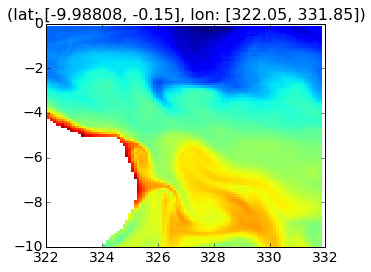

Too much land coverage to calculate spectra
Westend longtitude is:  322.05


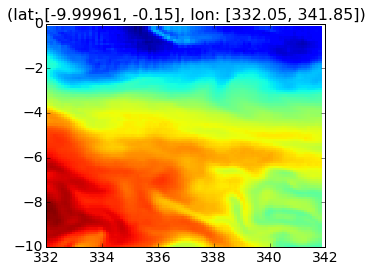

Index range (i):  3208 3307
Index range (j):  653 753
PSD slopes (Feb):  -2.86870592384


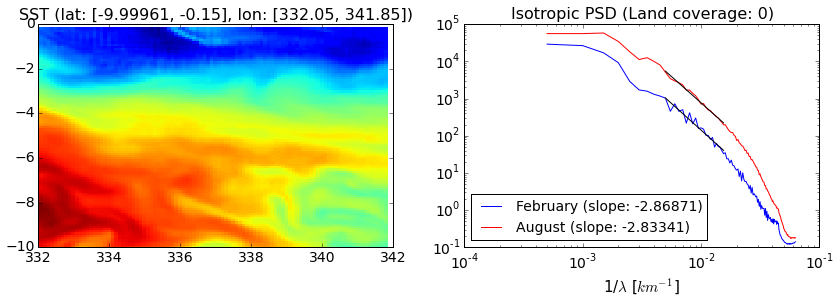

Westend longtitude is:  332.05


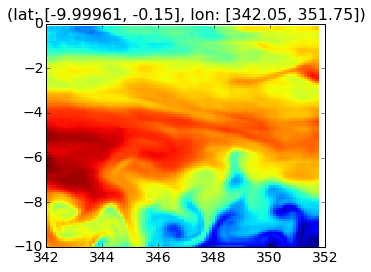

Index range (i):  3308 3406
Index range (j):  653 753
PSD slopes (Feb):  -2.67427497506


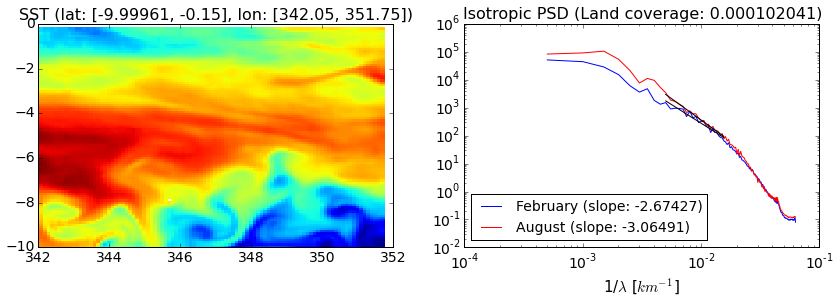

Westend longtitude is:  342.05


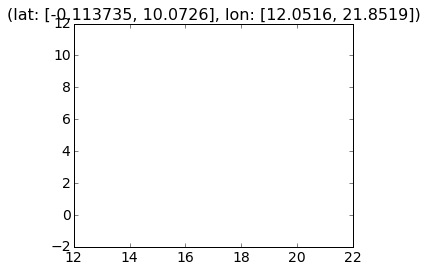

Too much land coverage to calculate spectra
Westend longtitude is:  12.0516090012
  Meridional range is:  -9.99960926952 -0.113735450091


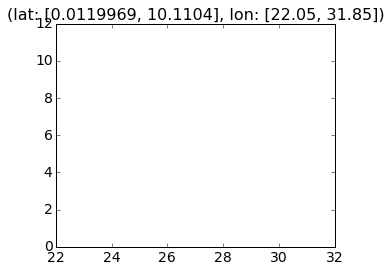

Too much land coverage to calculate spectra
Westend longtitude is:  22.05


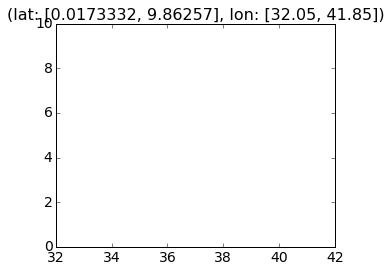

Too much land coverage to calculate spectra
Westend longtitude is:  32.05


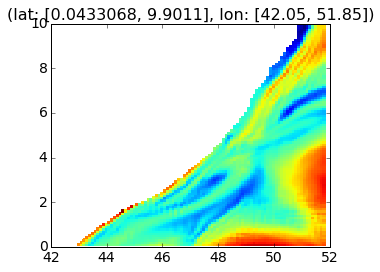

Too much land coverage to calculate spectra
Westend longtitude is:  42.05


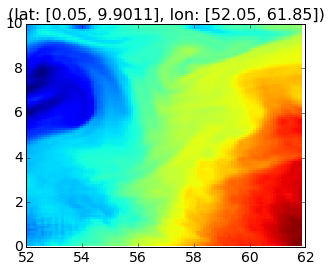

Index range (i):  408 507
Index range (j):  754 854
PSD slopes (Feb):  -2.96723071865


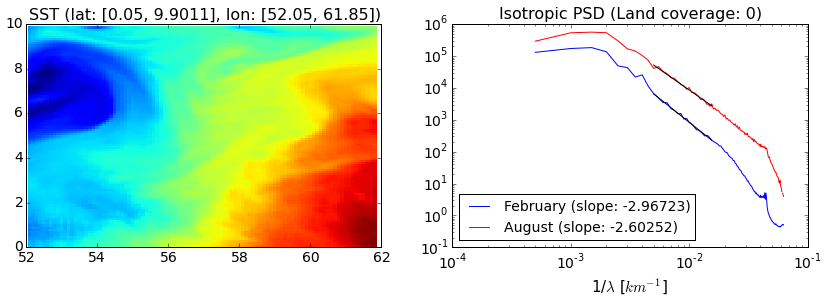

Westend longtitude is:  52.05


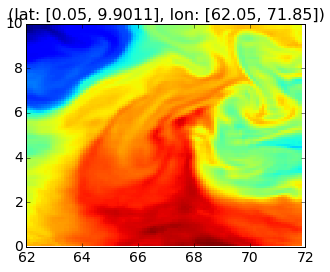

Index range (i):  508 607
Index range (j):  754 854
PSD slopes (Feb):  -2.37317921068


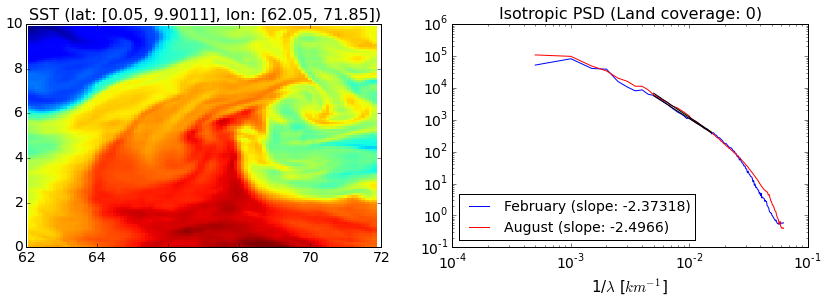

Westend longtitude is:  62.05


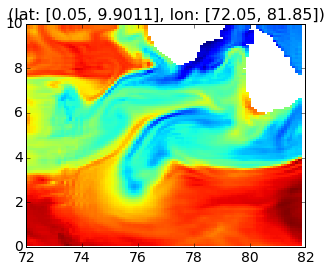

Too much land coverage to calculate spectra
Westend longtitude is:  72.05


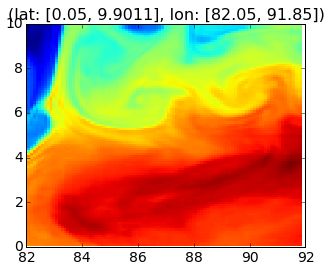

Index range (i):  708 807
Index range (j):  754 854
PSD slopes (Feb):  -2.4390428444


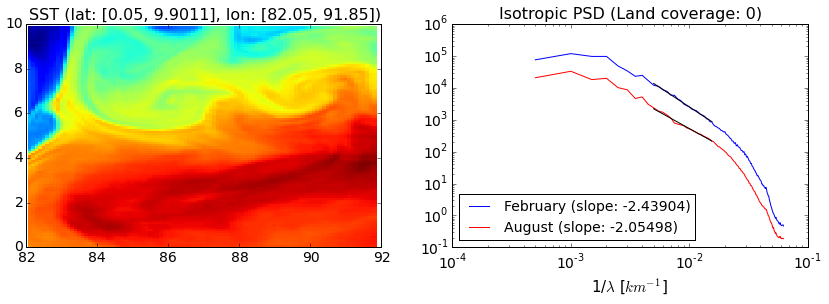

Westend longtitude is:  82.05


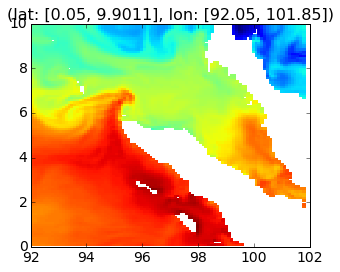

Too much land coverage to calculate spectra
Westend longtitude is:  92.05


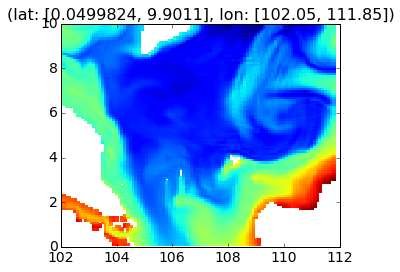

Too much land coverage to calculate spectra
Westend longtitude is:  102.05


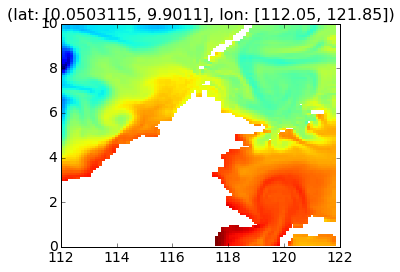

Too much land coverage to calculate spectra
Westend longtitude is:  112.05


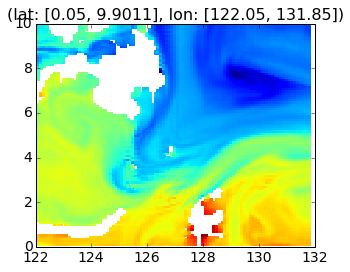

Too much land coverage to calculate spectra
Westend longtitude is:  122.05


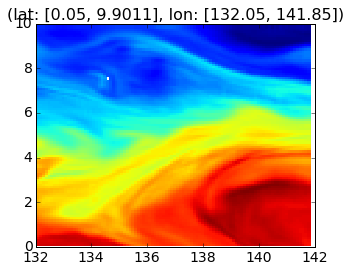

Index range (i):  1208 1307
Index range (j):  754 854
PSD slopes (Feb):  -2.201540277


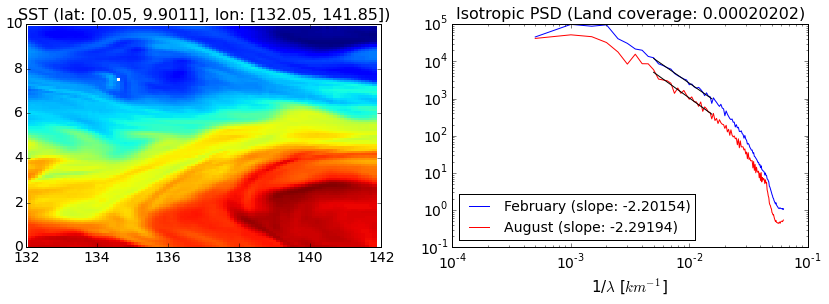

Westend longtitude is:  132.05


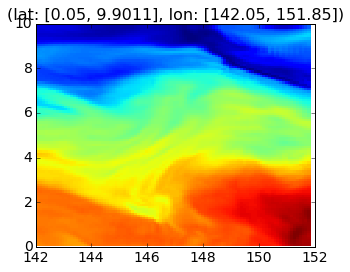

Index range (i):  1308 1407
Index range (j):  754 854
PSD slopes (Feb):  -2.08449881603


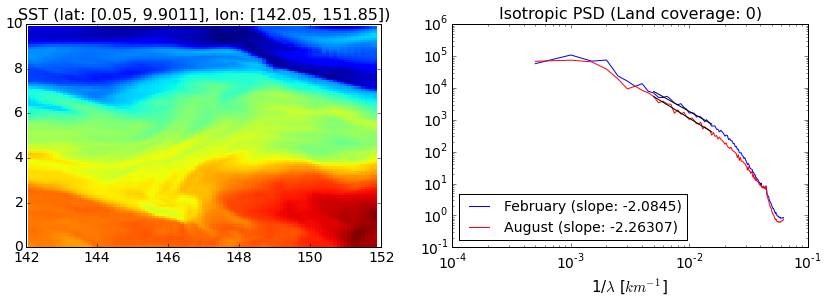

Westend longtitude is:  142.05


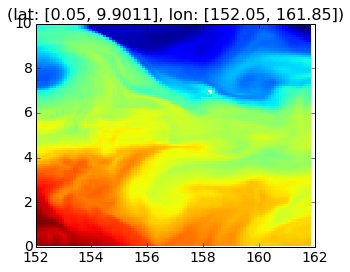

Index range (i):  1408 1507
Index range (j):  754 854
PSD slopes (Feb):  -1.98655876877


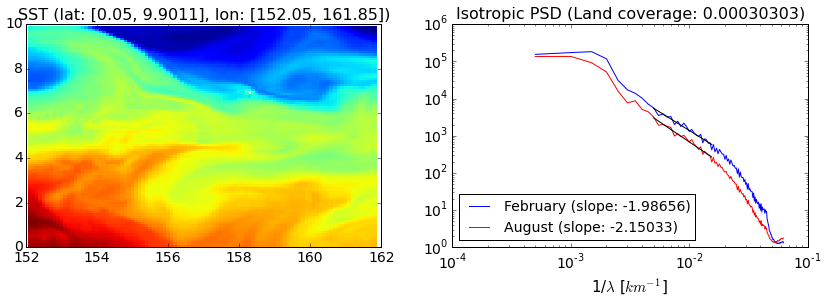

Westend longtitude is:  152.05


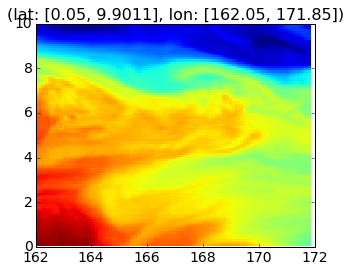

Index range (i):  1508 1607
Index range (j):  754 854
PSD slopes (Feb):  -2.14917857419


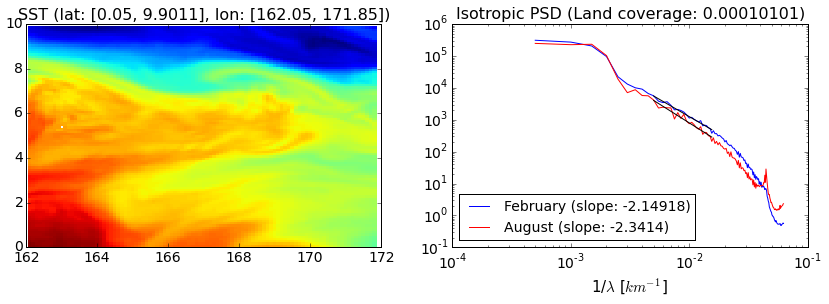

Westend longtitude is:  162.05


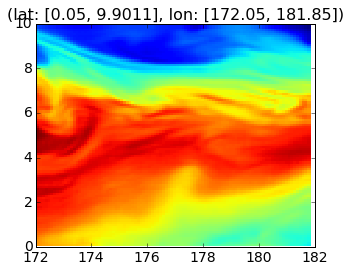

Index range (i):  1608 1707
Index range (j):  754 854
PSD slopes (Feb):  -2.37122779706


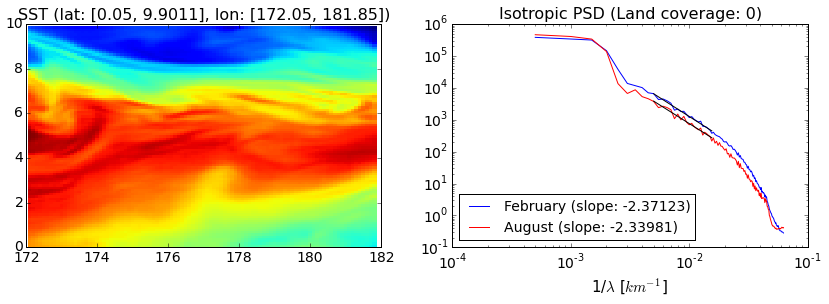

Westend longtitude is:  172.05


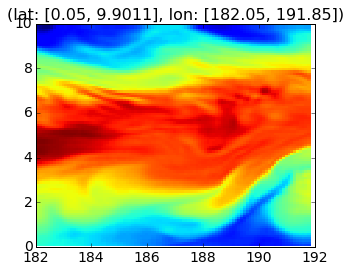

Index range (i):  1708 1807
Index range (j):  754 854
PSD slopes (Feb):  -2.76480812267


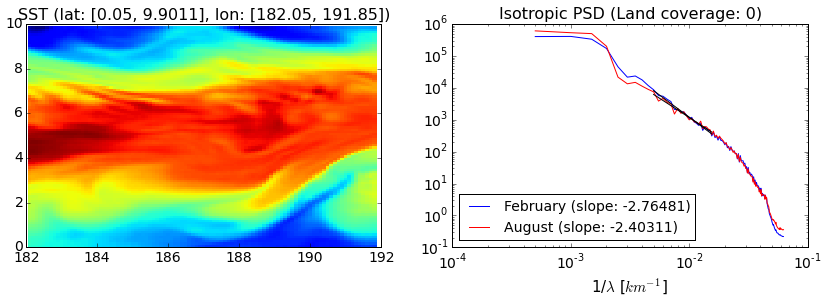

Westend longtitude is:  182.05


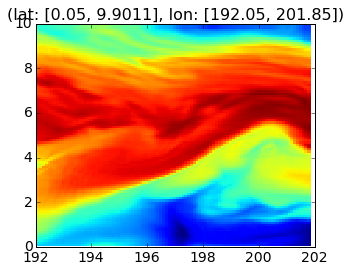

Index range (i):  1808 1907
Index range (j):  754 854
PSD slopes (Feb):  -2.63800499582


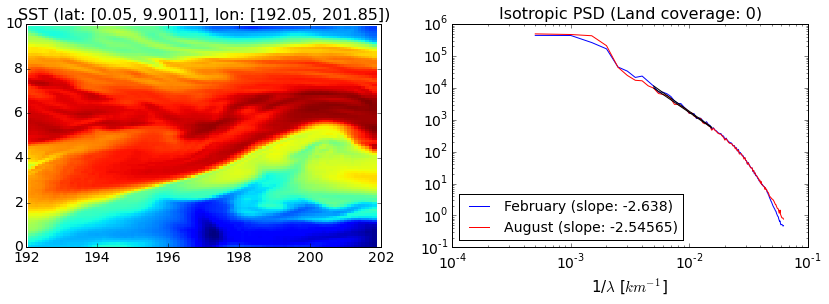

Westend longtitude is:  192.05


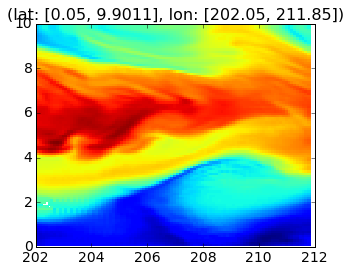

Index range (i):  1908 2007
Index range (j):  754 854
PSD slopes (Feb):  -2.63510587977


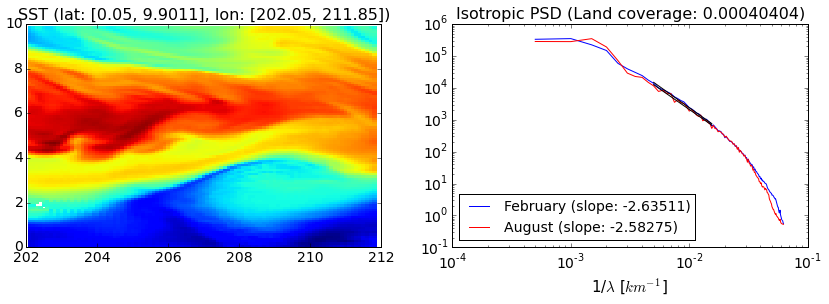

Westend longtitude is:  202.05


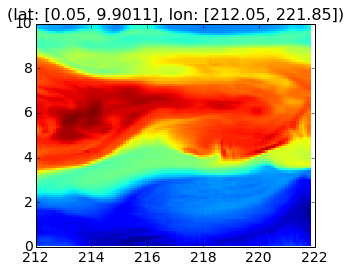

Index range (i):  2008 2107
Index range (j):  754 854
PSD slopes (Feb):  -2.71840086192


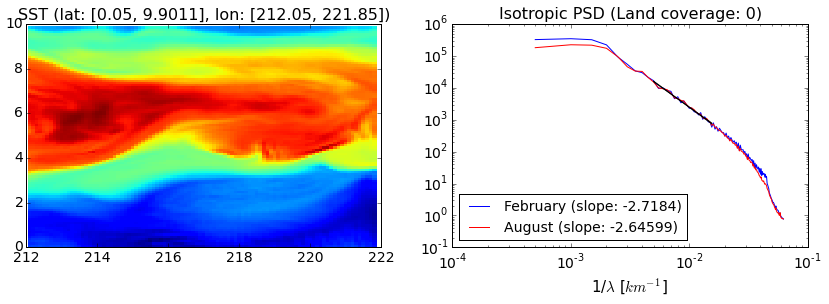

Westend longtitude is:  212.05


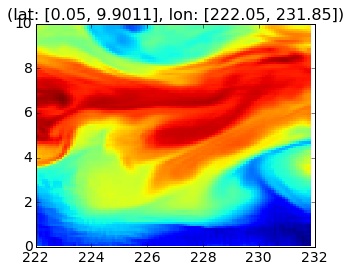

Index range (i):  2108 2207
Index range (j):  754 854
PSD slopes (Feb):  -2.72857519254


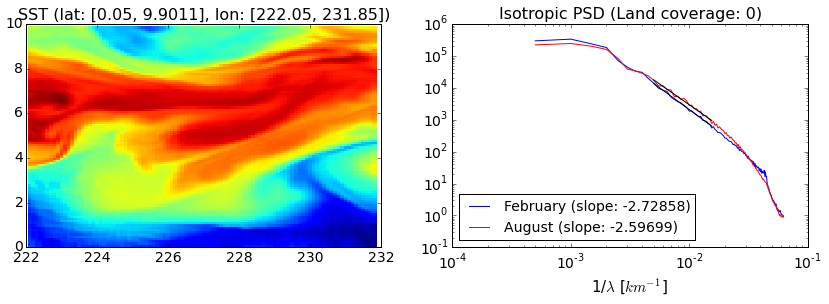

Westend longtitude is:  222.05


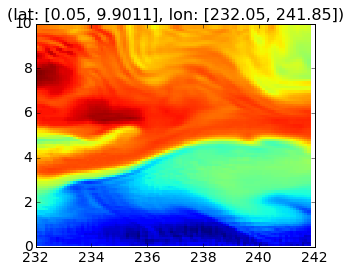

Index range (i):  2208 2307
Index range (j):  754 854
PSD slopes (Feb):  -2.53465581096


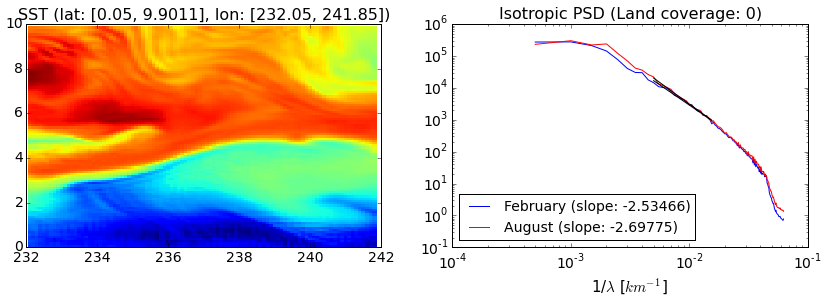

Westend longtitude is:  232.05


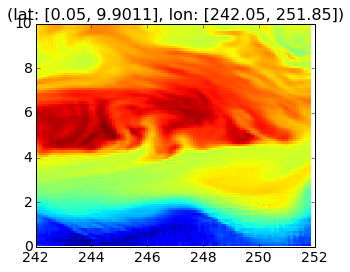

Index range (i):  2308 2407
Index range (j):  754 854
PSD slopes (Feb):  -2.2564050083


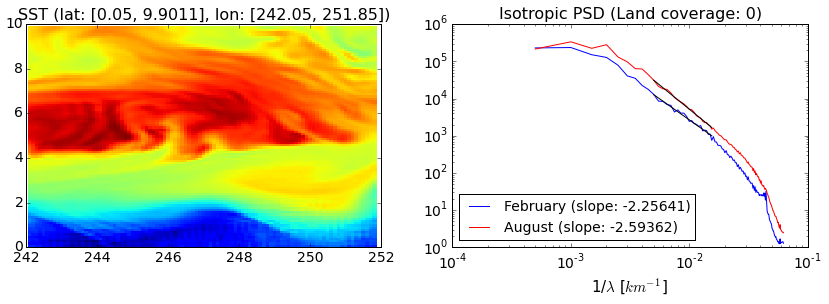

Westend longtitude is:  242.05


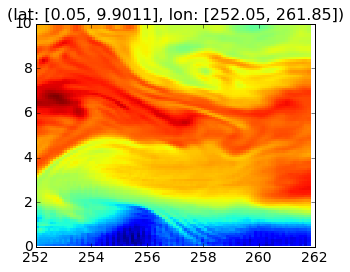

Index range (i):  2408 2507
Index range (j):  754 854
PSD slopes (Feb):  -2.37965869096


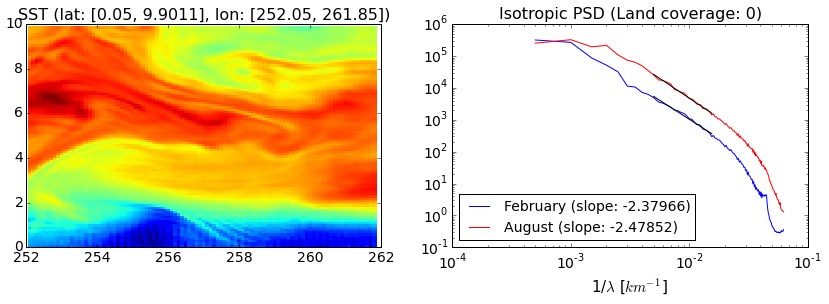

Westend longtitude is:  252.05


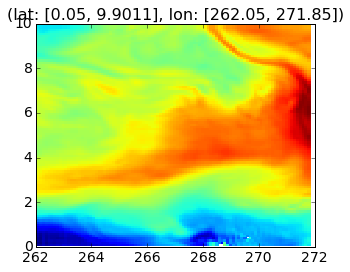

Index range (i):  2508 2607
Index range (j):  754 854
PSD slopes (Feb):  -2.39147044094


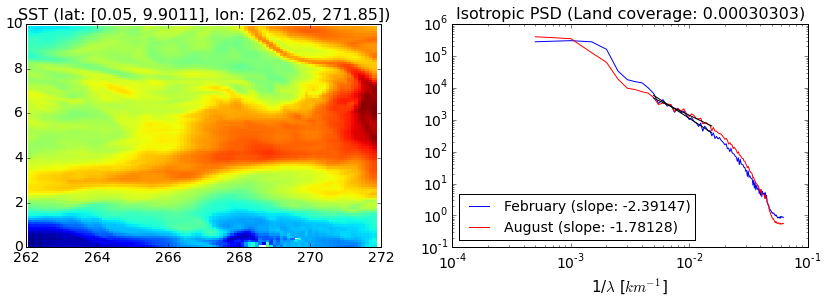

Westend longtitude is:  262.05


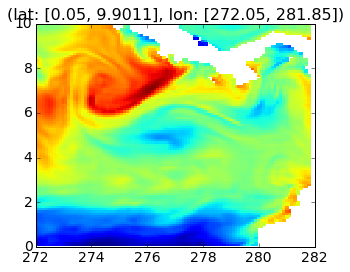

Too much land coverage to calculate spectra
Westend longtitude is:  272.05


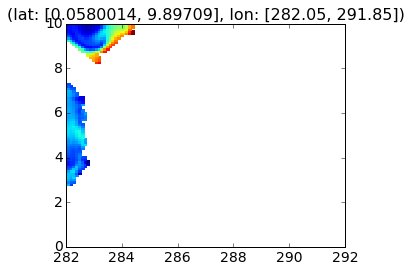

Too much land coverage to calculate spectra
Westend longtitude is:  282.05


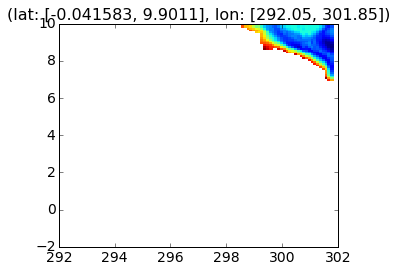

Too much land coverage to calculate spectra
Westend longtitude is:  292.05


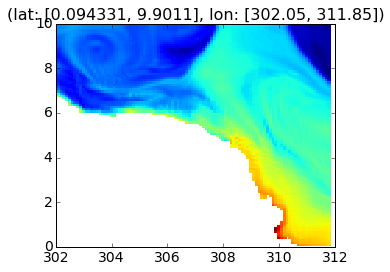

Too much land coverage to calculate spectra
Westend longtitude is:  302.05


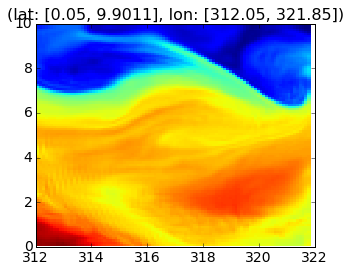

Index range (i):  3008 3107
Index range (j):  754 854
PSD slopes (Feb):  -2.61114652319


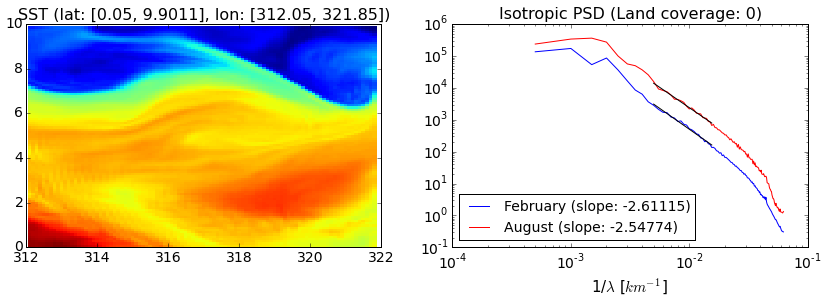

Westend longtitude is:  312.05


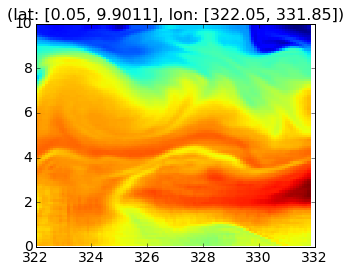

Index range (i):  3108 3207
Index range (j):  754 854
PSD slopes (Feb):  -2.65521631904


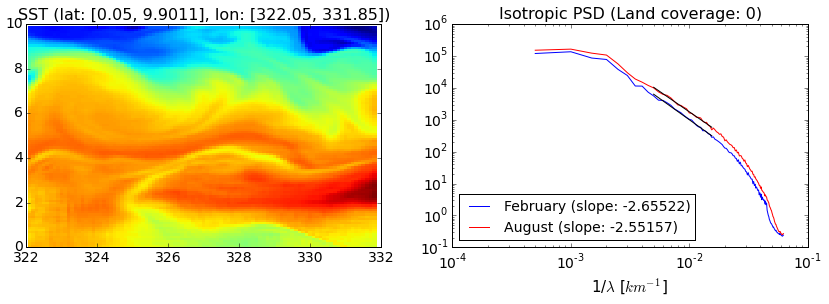

Westend longtitude is:  322.05


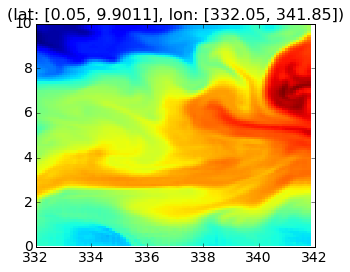

Index range (i):  3208 3307
Index range (j):  754 854
PSD slopes (Feb):  -2.77044656577


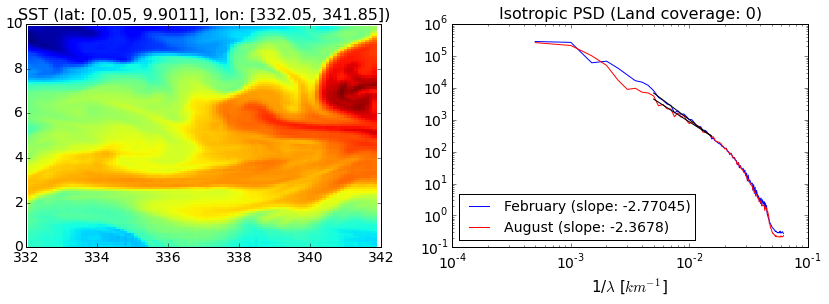

Westend longtitude is:  332.05


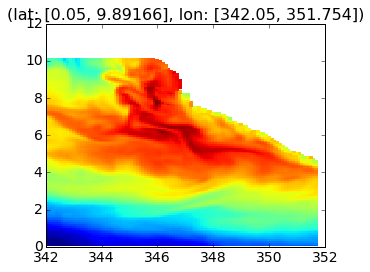

Too much land coverage to calculate spectra
Westend longtitude is:  342.05


In [101]:
#Lon_max = np.zeros((Degy,Degx))
#Lat_max = np.zeros((Degy,Degx))
#Lon_upright_corn = 0.
#Lat_upright_corn = 0.
psd_slopes_Feb_eq = np.zeros((Degy_eq+1,Degx_eq+1))
psd_slopes_Aug_eq = np.zeros((Degy_eq+1,Degx_eq+1))
psd_level_Feb_eq = np.zeros((Degy_eq+1,Degx_eq+1))
psd_level_Aug_eq = np.zeros((Degy_eq+1,Degx_eq+1))
L_1_eq = np.zeros((Degy_eq+1,Degx_eq+1)) 

j = 0
while south < lat_end_eq+dlat:
    west = lon_start
    east = west+dlon
    i = 0
    while west < lon_end+dlon:

        lonrange = np.array([west,east])
        latrange = np.array([south,north])
        lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
        latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
        boxidx = lonmask & latmask # this won't necessarily be square
        irange = np.where(boxidx.sum(axis=0))[0]
        imin, imax = irange.min(), irange.max()
        jrange = np.where(boxidx.sum(axis=1))[0]
        jmin, jmax = jrange.min(), jrange.max()

        SST_domain = SST[..., jmin:jmax, imin:imax]
        region_mask = mask_global[jmin:jmax, imin:imax]
        Ny, Nx = region_mask.shape
        land_fraction = region_mask.sum().astype('f8') / (Ny*Nx)
        #U_domain = U[..., jmin:jmax, imin:imax]
        
        plt.figure(figsize=(5,4))
        #plt.subplot(121)
        plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain)
        plt.title('(lat: [%g, %g], lon: [%g, %g])' % (tlat[jmin,imin], tlat[jmax-1,imax-1], tlon[jmin,imin], tlon[jmax-1,imax-1]), fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.show()
        
        if south < lat_end_eq+dlat:
            if west < lon_end+dlon:
                if land_fraction<crit:
                    print 'Index range (i): ', imin, imax
                    print 'Index range (j): ', jmin, jmax
                    # February
                    NtFeb = 0.
                    # load data files
                    nday = 1
                    for yearnum in np.arange(1,6):
                        daynum = 0
                        #for month in np.arange(1,13):
                        fname = os.path.join(base_dir,
                                 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-02-01.nc' 
                                 % (nday, yearnum+45))
                        #print fname
                        p = popmodel.POPFile(fname)
                        #T = p.nc.variables['SST'][:]
                        Nt_Feb, Nx, Ny, k, l, spac2_ave_Feb, tilde2_ave_Feb, breve2_ave_Feb, Ki, isospec_Feb, area, lon, lat, land_frac, MAX_LAND = p.power_spectrum_2d(
                                                                                roll=-1080, xmin=imin, xmax=imax, ymin=jmin, ymax=jmax, ymin_bound=jmin_bound, ymax_bound=jmax_bound, xmin_bound=imin_bound, xmax_bound=imax_bound)
                        if yearnum == 1:
                            N = len(Ki)
                            isospec_sum_Feb = np.zeros(N)
                        isospec_sum_Feb += isospec_Feb
                        #NtFeb += Nt_Feb

                    isospec_ave_Feb = isospec_sum_Feb/yearnum
        
                    # August
                    NtAug = 0.
                    # load data files
                    nday = 1
                    for yearnum in np.arange(1,6):
                        daynum = 0
                        #for month in np.arange(1,13):
                        fname = os.path.join(base_dir, 
                                 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-08-01.nc' 
                                 % (nday, yearnum+45))
                        #print fname
                        p = popmodel.POPFile(fname)
                        #T = p.nc.variables['SST'][:]
                        Nt_Aug, Nx, Ny, k, l, spac2_ave_Aug, tilde2_ave_Aug, breve2_ave_Aug, Ki, isospec_Aug, area, lon, lat, land_frac, MAX_LAND = p.power_spectrum_2d(
                                                                                roll=-1080, xmin=imin, xmax=imax, ymin=jmin, ymax=jmax, ymin_bound=jmin_bound, ymax_bound=jmax_bound, xmin_bound=imin_bound, xmax_bound=imax_bound)
                        if yearnum == 1:
                            N = len(Ki)
                            isospec_sum_Aug = np.zeros(N)
                        isospec_sum_Aug += isospec_Aug
                        #NtAug += Nt_Aug

                    isospec_ave_Aug = isospec_sum_Aug/yearnum
        
                    Ns = 10
                    Ne = N/4
                    ps_fit_Feb, ps_slope_Feb = fit_loglog(Ki[Ns:Ne], isospec_ave_Feb[Ns:Ne])
                    ps_fit_Aug, ps_slope_Aug = fit_loglog(Ki[Ns:Ne], isospec_ave_Aug[Ns:Ne])
        
        
                    #U_domain = U[..., jmin:jmax, imin:imax]

                    #Lon_eq[j,i] = tlon[jmin,imin]
                    #Lat_eq[j,i] = tlat[jmin,imin]
                    #Lon_max[j,i] = tlon[jmin,imax]
                    #Lat_max[j,i] = tlat[jmax,imin]
                    #Lon_upright_corn = tlon[jmax,imax]
                    #Lat_upright_corn = tlat[jmax,imax]
                    psd_slopes_Feb_eq[j,i] = ps_slope_Feb
                    psd_slopes_Aug_eq[j,i] = ps_slope_Aug
                    psd_level_Feb_eq[j,i] = ps_fit_Feb[-1]
                    psd_level_Aug_eq[j,i] = ps_fit_Aug[-1]
                    L_1_eq[j,i] = Ki[-1]
                    print 'PSD slopes (Feb): ', ps_slope_Feb
                    #if j == 0:
                    if north > -5. and north < 15.:
                        plt.figure(figsize=(14,4))
                        plt.subplot(121)
                        plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain)
                        plt.title('SST (lat: [%g, %g], lon: [%g, %g])' % (lat[0,0], lat[-1,-1], lon[0,0], lon[-1,-1]), fontsize=16)
                        plt.xticks(fontsize=14)
                        plt.yticks(fontsize=14)
                        plt.subplot(122)
                        plt.loglog(Ki*.5/np.pi*1e3, isospec_ave_Feb, 'b', label=r'February (slope: %g)' % ps_slope_Feb)
                        plt.loglog(Ki*.5/np.pi*1e3, isospec_ave_Aug, 'r', label=r'August (slope: %g)' % ps_slope_Aug)
                        plt.loglog(Ki[Ns:Ne]*.5/np.pi*1e3, ps_fit_Feb, 'k')
                        plt.loglog(Ki[Ns:Ne]*.5/np.pi*1e3, ps_fit_Aug, 'k')
                        plt.xlabel('1/$\lambda$ [$km^{-1}$]', fontsize=15)
                        plt.title('Isotropic PSD (Land coverage: %g)' % land_frac, fontsize=16)
                        plt.legend(loc='lower left', fontsize=14)
                        plt.xticks(fontsize=14)
                        plt.yticks(fontsize=14)
                        plt.show()
                else:
                    print 'Too much land coverage to calculate spectra'
                    #Lon_eq[j,i] = tlon[jmin,imin]
                    #Lat_eq[j,i] = tlat[jmin,imin]
                    #Lon_max[j,i] = tlon[jmin,imax]
                    #Lat_max[j,i] = tlat[jmax,imin]
                    #Lon_upright_corn = tlon[jmax,imax]
                    #Lat_upright_corn = tlat[jmax,imax]
                    psd_slopes_Feb_eq[j,i] = np.nan
                    psd_slopes_Aug_eq[j,i] = np.nan
                    psd_level_Feb_eq[j,i] = np.nan
                    psd_level_Aug_eq[j,i] = np.nan
                    L_1_eq[j,i] = np.nan
            
                    #plt.figure(figsize=(15,4))
                    #plt.subplot(121)
                    #plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain)
                    #plt.title('SST (Land coverage: %g)' % land_frac, fontsize=16)
                    #plt.xticks(fontsize=14)
                    #plt.yticks(fontsize=14)
            #if west > lon_end:
                #Lon_eq[j,i+1] = tlon[jmin,imax]
                #Lat_eq[j,i+1] = tlat[jmin,imax]
        #if south > lat_end:
            #Lon_eq[j+1,i] = tlon[jmax,imin]
            #Lat_eq[j+1,i] = tlat[jmax,imin]
        #if south > lat_end and west > lon_end:
            #Lon_eq[j+1,i+1] = tlon[jmax,imax]
            #Lat_eq[j+1,i+1] = tlat[jmax,imax]
        
        #if i>0:
        print 'Westend longtitude is: ', tlon[jmin,imin]
        if j>0 and i==0:
            print '  Meridional range is: ', Lat_eq[j-1,i], Lat_eq[j,i]

        
        #if i>0:
            #print 'Zonal range is: ', tlon[jmin,imin], tlon[jmin,imax]
        west = east
        east = west+dlon
        i += 1
    
    #if j>0 and i==0:
        #print ' Meridional range is: ', tlat[jmin,imin], Lat_global[jmax,imin]
    south = north
    north = south+dlat
    j += 1

(0.0, 34.0, 0.0, 2.0)

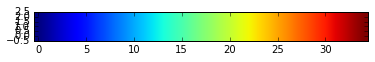

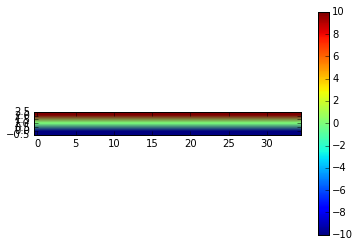

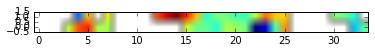

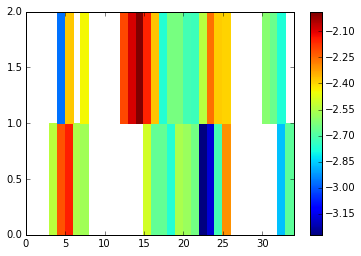

In [109]:
plt.figure()
plt.imshow(Lon_eq, origin='bottom')

plt.figure()
plt.imshow(Lat_eq, origin='bottom')
plt.colorbar()

plt.figure()
plt.imshow(psd_slopes_Feb_eq, origin='bottom')

plt.figure()
plt.pcolormesh(np.ma.masked_invalid(psd_slopes_Feb_eq))
plt.colorbar()
plt.axis('tight')

<matplotlib.colorbar.Colorbar instance at 0x7f0f469ba128>

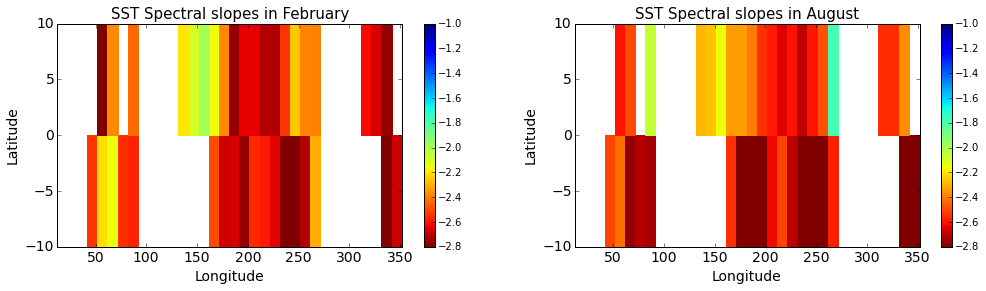

In [110]:
plt.figure(figsize=(17,4))
plt.subplot(121)
plt.pcolormesh(Lon_eq, Lat_eq, np.ma.masked_invalid(psd_slopes_Feb_eq), cmap='jet_r')
plt.title('SST Spectral slopes in February', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-2.8,-1])
plt.axis('tight')
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(Lon_eq, Lat_eq, np.ma.masked_invalid(psd_slopes_Aug_eq), cmap='jet_r')
plt.title('SST Spectral slopes in August', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-2.8,-1])
plt.axis('tight')
plt.colorbar()

In [ ]:
#roll = -1080
crit = 0.01
#fname_set = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc'
#f_set = netCDF4.Dataset(fname_set)
#mask = f_set.variables['KMT'][:] <= 1
#SST = np.roll(np.ma.masked_array(f_set.variables['SST'][0],mask), roll, axis=1)  # SST(time, lat, lon)
#U = np.roll(f.variables['U1_1'][0], roll)
#tlon = np.roll(np.ma.masked_array(f_set.variables['TLONG'][:],mask), roll, axis=1)[jmin_bound:jmax_bound,imin_bound:imax_bound]
#tlat = np.roll(np.ma.masked_array(f_set.variables['TLAT'][:],mask), roll, axis=1)[jmin_bound:jmax_bound,imin_bound:imax_bound]

#Ny, Nx = tlon.shape
#x = np.arange(0,Nx)
#y = np.arange(0,Ny)
#X,Y = np.meshgrid(x,y)
#Zr = tlon.ravel()
#Xr = np.ma.masked_array(X.ravel(), Zr.mask)
#Yr = np.ma.masked_array(Y.ravel(), Zr.mask)
#Xm = np.ma.masked_array( Xr.data, ~Xr.mask ).compressed()
#Ym = np.ma.masked_array( Yr.data, ~Yr.mask ).compressed()
#Zm = naiso.griddata(np.array([Xr.compressed(), Yr.compressed()]).T, 
#                                    Zr.compressed(), np.array([Xm,Ym]).T, method='linear')
#Znew = Zr.data
#Znew[Zr.mask] = Zm
#Znew.shape = tlon.shape
#tlon = Znew.copy()

#Zr = tlat.ravel()
#Xr = np.ma.masked_array(X.ravel(), Zr.mask)
#Yr = np.ma.masked_array(Y.ravel(), Zr.mask)
#Xm = np.ma.masked_array( Xr.data, ~Xr.mask ).compressed()
#Ym = np.ma.masked_array( Yr.data, ~Yr.mask ).compressed()
#Zm = naiso.griddata(np.array([Xr.compressed(), Yr.compressed()]).T, 
#                                    Zr.compressed(), np.array([Xm,Ym]).T, method='linear')
#Znew = Zr.data
#Znew[Zr.mask] = Zm
#Znew.shape = tlat.shape
#tlat = Znew.copy()


j,i = (0,0)
west, south = (lon_start, lat_start)
east, north = (west+dlon, south+dlat)

while south<=lat_end+dlat:
    west = lon_start
    east = west+dlon
    i = 0
    while west<=lon_end+dlon:

        lonrange = np.array([west,east])
        latrange = np.array([south,north])
        lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
        latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
        boxidx = lonmask & latmask # this won't necessarily be square
        irange = np.where(boxidx.sum(axis=0))[0]
        imin, imax = irange.min(), irange.max()
        jrange = np.where(boxidx.sum(axis=1))[0]
        jmin, jmax = jrange.min(), jrange.max()
        #print imin, imax, jmin, jmax
        
        
        region_mask = mask_global[jmin:jmax, imin:imax]
        Ny, Nx = region_mask.shape
        land_fraction = region_mask.sum().astype('f8') / (Ny*Nx)
        SST_domain = SST[..., jmin:jmax, imin:imax]

    
        if south <= lat_end:
            if west <= lon_end:
                if land_fraction<crit:
                    print 'Index range (i): ', imin, imax
                    print 'Index range (j): ', jmin, jmax
                    # February
                    NtFeb = 0.
                    # load data files
                    nday = 1
                    for yearnum in np.arange(1,6):
                        daynum = 0
                        #for month in np.arange(1,13):
                        fname = os.path.join(base_dir,
                                 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-02-01.nc' 
                                 % (nday, yearnum+45))
                        #print fname
                        p = popmodel.POPFile(fname)
                        #T = p.nc.variables['SST'][:]
                        Nt_Feb, Nx, Ny, k, l, spac2_ave_Feb, tilde2_ave_Feb, breve2_ave_Feb, Ki, isospec_Feb, area, lon, lat, land_frac, MAX_LAND = p.power_spectrum_2d(
                                                                                roll=-1080, xmin=imin, xmax=imax, ymin=jmin, ymax=jmax, ymin_bound=jmin_bound, ymax_bound=jmax_bound, xmin_bound=imin_bound, xmax_bound=imax_bound)
                        if yearnum == 1:
                            N = len(Ki)
                            isospec_sum_Feb = np.zeros(N)
                        isospec_sum_Feb += isospec_Feb
                        #NtFeb += Nt_Feb

                    isospec_ave_Feb = isospec_sum_Feb/yearnum
        
                    # August
                    NtAug = 0.
                    # load data files
                    nday = 1
                    for yearnum in np.arange(1,6):
                        daynum = 0
                        #for month in np.arange(1,13):
                        fname = os.path.join(base_dir, 
                                 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-08-01.nc' 
                                 % (nday, yearnum+45))
                        #print fname
                        p = popmodel.POPFile(fname)
                        #T = p.nc.variables['SST'][:]
                        Nt_Aug, Nx, Ny, k, l, spac2_ave_Aug, tilde2_ave_Aug, breve2_ave_Aug, Ki, isospec_Aug, area, lon, lat, land_frac, MAX_LAND = p.power_spectrum_2d(
                                                                                roll=-1080, xmin=imin, xmax=imax, ymin=jmin, ymax=jmax, ymin_bound=jmin_bound, ymax_bound=jmax_bound, xmin_bound=imin_bound, xmax_bound=imax_bound)
                        if yearnum == 1:
                            N = len(Ki)
                            isospec_sum_Aug = np.zeros(N)
                        isospec_sum_Aug += isospec_Aug
                        #NtAug += Nt_Aug

                    isospec_ave_Aug = isospec_sum_Aug/yearnum
        
                    Ns = 10
                    Ne = N/4
                    ps_fit_Feb, ps_slope_Feb = fit_loglog(Ki[Ns:Ne], isospec_ave_Feb[Ns:Ne])
                    ps_fit_Aug, ps_slope_Aug = fit_loglog(Ki[Ns:Ne], isospec_ave_Aug[Ns:Ne])
                    print 'PSD slopes (Feb): ', ps_slope_Feb
        
                    #U_domain = U[..., jmin:jmax, imin:imax]

                    #Lon_global[j,i] = tlon[jmin,imin]
                    #Lat_global[j,i] = tlat[jmin,imin]
                    #Lon_max[j,i] = tlon[jmin,imax]
                    #Lat_max[j,i] = tlat[jmax,imin]
                    #Lon_upright_corn = tlon[jmax,imax]
                    #Lat_upright_corn = tlat[jmax,imax]
                    psd_slopes_Feb_global[j,i] = ps_slope_Feb
                    psd_slopes_Aug_global[j,i] = ps_slope_Aug
                    psd_level_Feb_global[j,i] = ps_fit_Feb[-1]
                    psd_level_Aug_global[j,i] = ps_fit_Aug[-1]
                    L_1_global[j,i] = Ki[-1]
                    #if j == 0:
                    #if north > lat_end-2*dlat and north <= lat_end-dlat:
                    if north > -5. and north < 15.:
                        plt.figure(figsize=(14,4))
                        plt.subplot(121)
                        plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain)
                        plt.title('SST (lat: [%g, %g], lon: [%g, %g])' % (lat[0,0], lat[-1,-1], lon[0,0], lon[-1,-1]), fontsize=16)
                        plt.xticks(fontsize=14)
                        plt.yticks(fontsize=14)
                        plt.subplot(122)
                        plt.loglog(Ki*.5/np.pi*1e3, isospec_ave_Feb, 'b', label=r'February (slope: %g)' % ps_slope_Feb)
                        plt.loglog(Ki*.5/np.pi*1e3, isospec_ave_Aug, 'r', label=r'August (slope: %g)' % ps_slope_Aug)
                        plt.loglog(Ki[Ns:Ne]*.5/np.pi*1e3, ps_fit_Feb, 'k')
                        plt.loglog(Ki[Ns:Ne]*.5/np.pi*1e3, ps_fit_Aug, 'k')
                        plt.xlabel('1/$\lambda$ [$km^{-1}$]', fontsize=15)
                        plt.title('Isotropic PSD (Land coverage: %g)' % land_frac, fontsize=16)
                        plt.legend(loc='lower left', fontsize=14)
                        plt.xticks(fontsize=14)
                        plt.yticks(fontsize=14)
                        plt.show()
                else:
                    print 'Too much land coverage to calculate spectra'
                    #Lon_global[j,i] = tlon[jmin,imin]
                    #Lat_global[j,i] = tlat[jmin,imin]
                    #Lon_max[j,i] = tlon[jmin,imax]
                    #Lat_max[j,i] = tlat[jmax,imin]
                    #Lon_upright_corn = tlon[jmax,imax]
                    #Lat_upright_corn = tlat[jmax,imax]
                    psd_slopes_Feb_global[j,i] = np.nan
                    psd_slopes_Aug_global[j,i] = np.nan
                    psd_level_Feb_global[j,i] = np.nan
                    psd_level_Aug_global[j,i] = np.nan
                    L_1_global[j,i] = np.nan
            
                    #plt.figure(figsize=(15,4))
                    #plt.subplot(121)
                    #plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain)
                    #plt.title('SST (Land coverage: %g)' % land_frac, fontsize=16)
                    #plt.xticks(fontsize=14)
                    #plt.yticks(fontsize=14)
            #else:
                #Lon_global[j,i] = tlon[jmin,imin]
                #Lat_global[j,i] = tlat[jmin,imin]
        #else:
            #Lon_global[j,i] = tlon[jmin,imin]
            #Lat_global[j,i] = tlat[jmin,imin]
        
        if i>0:
            print 'Zonal range is: ', Lon_global[j,i-1], Lon_global[j,i]
        if j>0 and i==0:
            print '  Meridional range is: ', Lat_global[j-1,i], Lat_global[j,i]
        west = east
        east = west+dlon
        i += 1
    
    south = north
    north = south+dlat
    j += 1
    
    
        

-c:52: RuntimeWarning: invalid value encountered in greater_equal
-c:52: RuntimeWarning: invalid value encountered in less
-c:53: RuntimeWarning: invalid value encountered in greater_equal
-c:53: RuntimeWarning: invalid value encountered in less
sstanalysis/popmodel.py:454: RuntimeWarning: invalid value encountered in divide
  np.bincount(Kidx, weights=(breve2_ave).ravel()) / area )[1:] *Ki*2.*np.pi**2


Index range (i):  8 107
Index range (j):  0 174
PSD slopes (Feb):  -2.26749744027
Index range (i):  108 207
Index range (j):  0 174
PSD slopes (Feb):  -2.0409877446
Zonal range is:  12.0 22.0
Index range (i):  208 307
Index range (j):  0 174
PSD slopes (Feb):  -2.25533712953
Zonal range is:  22.0 32.0
Index range (i):  308 407
Index range (j):  0 174
PSD slopes (Feb): 

In [ ]:
fname = 'psd_slope_SST_Global.mat' 
#fw = open(filename, 'w')
io.savemat(fname, {'Feb':psd_slopes_Feb_global, 'Aug':psd_slopes_Aug_global, 'Lat':Lat_global, 'Lon':Lon_global})

fname = 'psd_level_SST_Global.mat' 
#fw = open(filename, 'w')
io.savemat(fname, {'Feb':psd_level_Feb_global, 'Aug':psd_level_Aug_global, 'LenScale':(L_1_global*.5/np.pi)**-1*1e-3})

In [ ]:
fname = 'psd_slope_SST_Global.mat'
f_psd = io.loadmat(fname)

print f_psd.keys()

In [ ]:
psd_slopes_Feb = f_psd['Feb']
psd_slopes_Aug = f_psd['Aug']
Lon = f_psd['Lon']
Lat = f_psd['Lat']

In [ ]:
plt.figure(figsize=(17,4))
plt.subplot(121)
plt.pcolormesh(np.ma.masked_invalid(Lon), np.ma.masked_invalid(Lat), np.ma.masked_invalid(psd_slopes_Feb), cmap='jet_r')
plt.title('SST Spectral slopes in February', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-2.8,-1])
#plt.axis('tight')
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(np.ma.masked_invalid(Lon), np.ma.masked_invalid(Lat), np.ma.masked_invalid(psd_slopes_Aug), cmap='jet_r')
plt.title('SST Spectral slopes in August', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-2.8,-1])
#plt.axis('tight')
plt.colorbar()